# Project 4: West Nile Virus Classification
---
Project notebook organisation:<br>
**1 - Exploratory Data Analysis** (current notebook)<br><br>
<font color='red'> update links</font><br><br>
[2 - Feature Engineering](./2_exploratory_data_analysis_and_preprocessing.ipynb)<br>
[3 - Model Tuning and Insights](./3_model_tuning_and_insights.ipynb)<br>
<br>
<br>

In [1]:
# import libraries
import pandas as pd, numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns

import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geopy.distance import geodesic

import datetime as dt

import shapely
from shapely import geometry
from shapely import ops
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import nearest_points

import warnings
warnings.filterwarnings('ignore')

import featuretools as ft

sns.set_style('ticks')

pd.set_option('display.max_columns', None)

%matplotlib inline

# # installing less common packages (uncomment if you do not have these installed)
# !pip install geopy
# !pip install geopandas

ModuleNotFoundError: No module named 'featuretools'

# Introduction
---

West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States. Mosquitoes become infected when they feed on infected birds. Infected mosquitoes then spread West Nile virus to people and other animals by biting them. It is most commonly spread to people by the bite of an infected mosquito. Cases of WNV occur during mosquito season, which starts in the summer and continues through fall.

There are no vaccines to prevent or medications to treat WNV in people. Fortunately, most people infected with WNV do not feel sick. About 1 in 5 people who are infected develop a fever and other symptoms. About 1 out of 150 infected people develop a serious, sometimes fatal, illness. 

> CDC (https://www.cdc.gov/westnile/index.html)

# Problem Statement
---

The goal of this project was to predict the occurrence of West Nile Virus (WNV) in Chicago, IL given time, location and species.

# Exploratory Data Analysis
---

In [2]:
trap = pd.read_csv('./assets/train.csv', parse_dates=['Date'])
test = pd.read_csv('./assets/test.csv', parse_dates=['Date'])
spray = pd.read_csv('./assets/spray.csv', parse_dates=['Date'])
weather = pd.read_csv('./assets/weather.csv', parse_dates=['Date'])

In [3]:
# getting some basic information about each dataframe
# shape of dataframe i.e. number of rows and columns
# total number of rows with null values
# total number of duplicates
# data types of columns

def basic_eda(df, df_name):
    print(df_name.upper())
    print()
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print()
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    print(df.dtypes)
    print("-----\n")

In [4]:
dfs = [
    (trap, 'trap'),
    (spray, 'spray'),
    (weather, 'weather'),
    (test, 'test')
    ]

In [5]:
[basic_eda(df, name) for df, name in dfs]

TRAP

Rows: 10506 	 Columns: 12

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 1062
Percentage dupe rows: 10.11%

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
dtype: object
-----

SPRAY

Rows: 14835 	 Columns: 4

Total null rows: 584
Percentage null rows: 3.94%

Total duplicate rows: 543
Percentage dupe rows: 3.66%

Date         datetime64[ns]
Time                 object
Latitude            float64
Longitude           float64
dtype: object
-----

WEATHER

Rows: 2944 	 Columns: 22

Total null rows: 0
Percentage null rows: 0.0

[None, None, None, None]

## Traps

This dataframe contains information associated with each mosquito trap deployed across the city of Chicago. The location of the traps are described by the block number and street name which have been conveniently mapped into Latitude and Longitude.

In [6]:
print(trap.Date.min())
print(trap.Date.max())
trap.head()

2007-05-29 00:00:00
2013-09-26 00:00:00


Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

### Mosquito species

Although all species sampled are carriers of WNV, the presence of WNV was tested positive for <i>Culex restuans</i>, <i>C. pipiens</i>, and <i>C.pipiens/restuans</i>. In addition, these 3 categories made up more than 96% of the sample of the species sampled.

(https://www.cdc.gov/westnile/resources/pdfs/MosquitoSpecies1999-2016.pdf).

In [7]:
# what species are there
print(f'number of species: {trap["Species"].nunique()}')
trap["Species"].value_counts(normalize=True)

number of species: 7


CULEX PIPIENS/RESTUANS    0.452313
CULEX RESTUANS            0.260803
CULEX PIPIENS             0.256901
CULEX TERRITANS           0.021131
CULEX SALINARIUS          0.008186
CULEX TARSALIS            0.000571
CULEX ERRATICUS           0.000095
Name: Species, dtype: float64

Text(0.5, 1.0, 'total number of samples collected for each species')

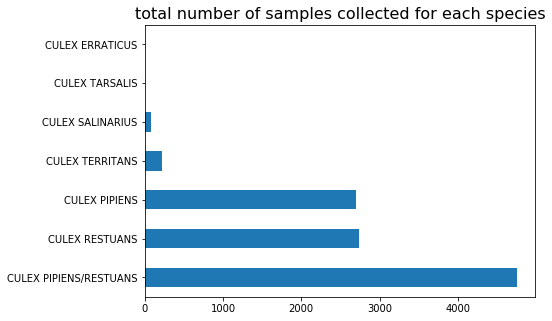

In [8]:
trap['Species'].value_counts().plot(kind='barh', figsize=(7,5))
plt.title('total number of samples collected for each species', fontsize=16)

Species that are tested positive for West Nile Virus.

                        NumMosquitos  WnvPresent
Species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44671         240
CULEX PIPIENS/RESTUANS         66268         262
CULEX RESTUANS                 23431          49
CULEX SALINARIUS                 145           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  510           0


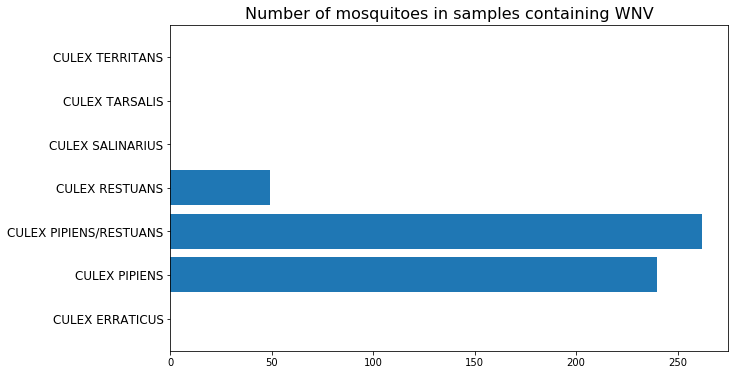

In [9]:
mos_wnv = trap[['Species', 'NumMosquitos', 'WnvPresent']].groupby(by='Species').sum()
print(mos_wnv)
mos_wnv.reset_index(inplace=True)
plt.figure(figsize=(10,6))
plt.barh(mos_wnv['Species'], mos_wnv['WnvPresent'])
plt.title('Number of mosquitoes in samples containing WNV', fontsize=16)
plt.yticks(fontsize=12)
plt.show()

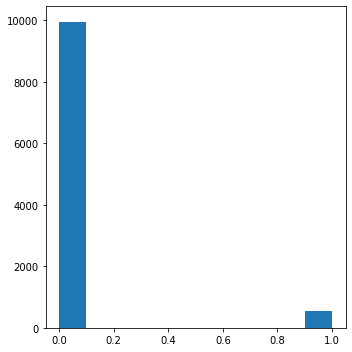

In [10]:
plt.figure(figsize=(5,5))
plt.hist(trap.WnvPresent)
# plt.title('WNV presence by mosquito species', fontsize=16)
# plt.yticks(fontsize=12)
# plt.ylabel('')
# plt.xlabel('Total number of mosquitos',fontsize=14)
plt.tight_layout()

### Add datetime columns

In [11]:
# make datetime columns
trap['year'] = trap['Date'].apply(lambda x:x.year)
trap['month'] = trap['Date'].apply(lambda x:x.month)
trap['weekofyear'] = trap['Date'].apply(lambda x:x.weekofyear)
trap['yearmonth'] = trap['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

# year 2007 - 2013
print(trap.year.value_counts().sort_index())

# data only from may - oct
print(trap.month.value_counts())

# week 22 - 41
print(trap.weekofyear.value_counts().sort_index())

# total number of weeks in dataset
print(trap.weekofyear.nunique())

2007    3811
2009    2249
2011    2054
2013    2392
Name: year, dtype: int64
8     3751
7     2606
9     2218
6     1571
10     276
5       84
Name: month, dtype: int64
22      84
23     383
24     321
25     332
26     504
27     105
28     981
29     591
30     738
31    1241
32     743
33     804
34     784
35     513
36     431
37     532
38     675
39     468
40     250
41      26
Name: weekofyear, dtype: int64
20


### Combine mosquito counts

As the test results are organized in a way that the number of mosquitoes are capped at 50 for each record
even when the samples are collected on the same day. We will combine these records into a single record.

In [12]:
trap = trap.groupby([col for col in trap.columns if col != 'NumMosquitos']).sum()
trap.reset_index(inplace=True)
trap.head()

Date                                           Address  \
0 2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1 2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2 2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3 2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4 2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8   

   WnvPresent  year  month  weekofyear yearmonth  NumMosquitos  
0           0  2007      5          22   2007-05             1  
1           0  2007      5          22   2007-05             2  
2           0  2007      5          22   2007-05             1  
3           0  2007      5          22   2007-05             1  
4           0  2007      5          22   2007-05             1

### Number of traps and sampling effort

In [13]:
trap['Trap'].nunique()

136

T900     182
T115     158
T135     153
T002     150
T151     144
        ... 
T078       6
T094B      5
T076       5
T237       3
T040       2
Name: Trap, Length: 136, dtype: int64


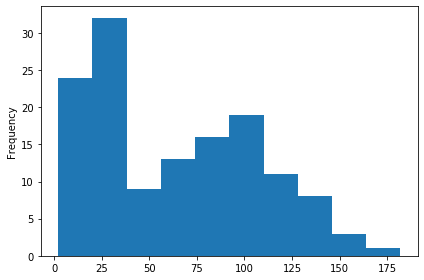

In [14]:
print(trap.Trap.value_counts())
trap.Trap.value_counts().plot(kind='hist')
plt.tight_layout()

- There are 136 traps.
- T900 (at Ohare airport) is sampled the most

### Duplicate addresses for each trap

In [15]:
trap[trap.Trap=='T035'].AddressNumberAndStreet.value_counts()

5100  W 72ND ST, Chicago, IL      45
3000  S HOYNE AVE, Chicago, IL    27
Name: AddressNumberAndStreet, dtype: int64

In [16]:
trap[trap.Trap=='T009'].AddressNumberAndStreet.value_counts()

9100  W HIGGINS RD, Chicago, IL     70
9100  W HIGGINS AVE, Chicago, IL    27
Name: AddressNumberAndStreet, dtype: int64

T035 is probably mislabeled for one of the addresses while T009 is probably a typo. Since coordinates are already present, trap numbers aren't important. Therefore all other location columns such as addresses and `Trap` will be dropped.

### Univariate EDA

#### Distributions

In [17]:
# distribution plots (histogram, boxplot, probplot)
def dist_plots(df, list_of_columns):
    nrows = len(list_of_columns)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize=(15, nrows*3.5))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.distplot(df[col], ax = ax[i*3-3], fit = stats.norm)
        ax[i*3-3].set_title(f'{col} distribution plot',fontsize=14)
        ax[i*3-3].tick_params(labelsize=12)
        ax[i*3-3].set_xlabel(col, fontsize=14)
        
        sns.boxplot(df[col], width = 0.2, ax = ax[i*3-2])
        ax[i*3-2].set_title(f'{col} box plot',fontsize=14)
        ax[i*3-2].tick_params(labelsize=12)
        ax[i*3-2].set_xlabel(col, fontsize=14)
        
        stats.probplot(df[col], plot = ax[i*3-1])
        ax[i*3-1].set_title(f'{col} probability plot', fontsize=14)
        ax[i*3-1].tick_params(labelsize=12)
        ax[i*3-1].set_xlabel(col, fontsize=14)
    plt.tight_layout()

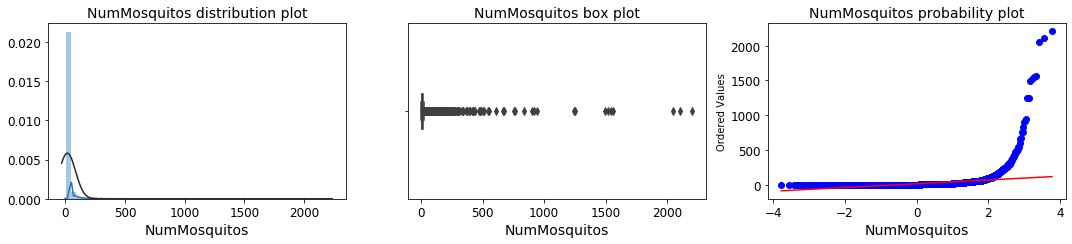

In [18]:
dist_plots(trap, ['NumMosquitos'])

#### Sampling efforts and WNV presence per year

Sampling efforts varied quite a bit between years, with 2007 having the most unique traps being sampled everyday, followed by 2013. This corresponds to the years with the highest WNV presence. This should be taken into consideration when modelling as sampling efforts would affect WNV detectability.

WNV also tends to peak in August.

In [19]:
# get number of unique traps sampled per day
year = trap.groupby(['year','Date','Latitude','Longitude']).count()[['Species']]
year = year.reset_index()

# total number of unique traps sampled per day, by year
year.year.value_counts().sort_index()

2007    1459
2009    1006
2011     988
2013    1163
Name: year, dtype: int64

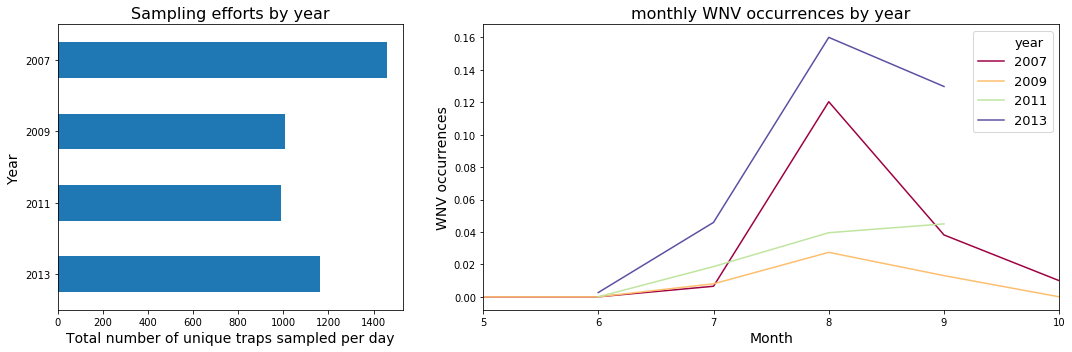

In [20]:
fig, ax = plt.subplots(ncols = 2, figsize=(15,5),  gridspec_kw={'width_ratios': [3, 5]})

# plot sampling efforts by year
year.year.value_counts().sort_index(ascending=False).plot(kind = 'barh', ax = ax[0])
ax[0].set_title('Sampling efforts by year', fontsize=16)
ax[0].set_ylabel('Year',fontsize=14)
ax[0].set_xlabel('Total number of unique traps sampled per day',fontsize=14)

# plot WNV occurrence by month and year
wnv = trap[['Date','WnvPresent','year','month']]
sns.lineplot(x = wnv.month,y = 'WnvPresent', data = wnv, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral', ax = ax[1])
ax[1].legend(fontsize = 13)
ax[1].set_title('monthly WNV occurrences by year', fontsize=16)
ax[1].set_xlabel('Month',fontsize=14)
ax[1].set_ylabel('WNV occurrences',fontsize=14)
ax[1].set_xlim(wnv.month.min(), wnv.month.max())
plt.tight_layout()

#### Number of traps and sampling effort

- There are 136 traps.
- T900 (at Ohare airport) is sampled the most

In [21]:
trap.Trap.nunique()

136

T900     182
T115     158
T135     153
T002     150
T151     144
        ... 
T078       6
T094B      5
T076       5
T237       3
T040       2
Name: Trap, Length: 136, dtype: int64


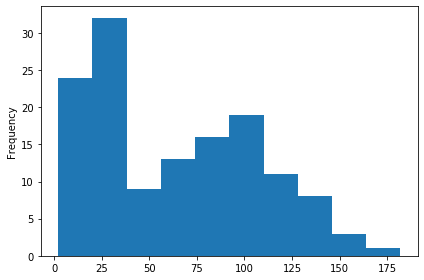

In [22]:
print(trap.Trap.value_counts())
trap.Trap.value_counts().plot(kind='hist')
plt.tight_layout()

In [23]:
trap[trap.Trap=='T900'].head()

Date                                            Address  \
2881 2009-05-28  ORD Terminal 5, O'Hare International Airport, ...   
2983 2009-06-03  ORD Terminal 5, O'Hare International Airport, ...   
2984 2009-06-03  ORD Terminal 5, O'Hare International Airport, ...   
3051 2009-06-05  ORD Terminal 5, O'Hare International Airport, ...   
3052 2009-06-05  ORD Terminal 5, O'Hare International Airport, ...   

                     Species  Block            Street  Trap  \
2881          CULEX RESTUANS     10   W OHARE AIRPORT  T900   
2983  CULEX PIPIENS/RESTUANS     10   W OHARE AIRPORT  T900   
2984          CULEX RESTUANS     10   W OHARE AIRPORT  T900   
3051  CULEX PIPIENS/RESTUANS     10   W OHARE AIRPORT  T900   
3052          CULEX RESTUANS     10   W OHARE AIRPORT  T900   

                  AddressNumberAndStreet   Latitude  Longitude  \
2881  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
2983  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
2984  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
3051  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
3052  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   

      AddressAccuracy  WnvPresent  year  month  weekofyear yearmonth  \
2881                9           0  2009      5          22   2009-05   
2983                9           0  2009      6          23   2009-06   
2984                9           0  2009      6          23   2009-06   
3051                9           0  2009      6          23   2009-06   
3052                9           0  2009      6          23   2009-06   

      NumMosquitos  
2881            34  
2983           254  
2984            80  
3051            10  
3052             2

## Spray

In [24]:
spray = pd.read_csv('./assets/spray.csv', parse_dates=['Date'])
print(spray.shape)
spray.head()

(14835, 4)


Date        Time   Latitude  Longitude
0 2011-08-29  6:56:58 PM  42.391623 -88.089163
1 2011-08-29  6:57:08 PM  42.391348 -88.089163
2 2011-08-29  6:57:18 PM  42.391022 -88.089157
3 2011-08-29  6:57:28 PM  42.390637 -88.089158
4 2011-08-29  6:57:38 PM  42.390410 -88.088858

In [25]:
# create another copy of spray to work on
spray1 = spray.copy()

### Handling null values and duplicates

Examine spray dataset for null values

In [26]:
spray1[spray1.isna().any(axis=1)]

Date Time   Latitude  Longitude
1030 2011-09-07  NaN  41.987092 -87.794286
1031 2011-09-07  NaN  41.987620 -87.794382
1032 2011-09-07  NaN  41.988004 -87.794574
1033 2011-09-07  NaN  41.988292 -87.795486
1034 2011-09-07  NaN  41.988100 -87.796014
...         ...  ...        ...        ...
1609 2011-09-07  NaN  41.995876 -87.811615
1610 2011-09-07  NaN  41.995972 -87.810271
1611 2011-09-07  NaN  41.995684 -87.810319
1612 2011-09-07  NaN  41.994724 -87.810415
1613 2011-09-07  NaN  41.993092 -87.810415

[584 rows x 4 columns]

Looks like `Time` is the main source of NaN cells? Let's check if other columns have NaN

In [27]:
spray1.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

We've confirmed that all the null rows were caused by missing data for `Time`. Time data is probably too finely tuned for our needs, so we might drop `Time` from spray instead. 

But first, we want to explore our duplicate spray rows.

In [28]:
# looking at our dupes
spray1[spray1.duplicated(keep=False)].head(20)

Date        Time   Latitude  Longitude
484 2011-09-07  7:43:40 PM  41.983917 -87.793088
485 2011-09-07  7:43:40 PM  41.983917 -87.793088
489 2011-09-07  7:44:32 PM  41.986460 -87.794225
490 2011-09-07  7:44:32 PM  41.986460 -87.794225
491 2011-09-07  7:44:32 PM  41.986460 -87.794225
492 2011-09-07  7:44:32 PM  41.986460 -87.794225
493 2011-09-07  7:44:32 PM  41.986460 -87.794225
494 2011-09-07  7:44:32 PM  41.986460 -87.794225
495 2011-09-07  7:44:32 PM  41.986460 -87.794225
496 2011-09-07  7:44:32 PM  41.986460 -87.794225
497 2011-09-07  7:44:32 PM  41.986460 -87.794225
498 2011-09-07  7:44:32 PM  41.986460 -87.794225
499 2011-09-07  7:44:32 PM  41.986460 -87.794225
500 2011-09-07  7:44:32 PM  41.986460 -87.794225
501 2011-09-07  7:44:32 PM  41.986460 -87.794225
502 2011-09-07  7:44:32 PM  41.986460 -87.794225
503 2011-09-07  7:44:32 PM  41.986460 -87.794225
504 2011-09-07  7:44:32 PM  41.986460 -87.794225
505 2011-09-07  7:44:32 PM  41.986460 -87.794225
506 2011-09-07  7:44:32 PM  41.986460 -87.794225

It's not clear from the data dictonary from Kaggle why there are duplicate records for spray, down to the exact timing. Perhaps multiple rows are meant to indicate the number of times a location was sprayed on one day, to serve as a proxy for total dosage?

In [29]:
# examing one of the records that have a lot of duplicates
spray1.loc[(spray1["Date"] == "2011-09-07") & (spray1["Latitude"]==41.986460) & (spray1["Longitude"]==-87.794225)]

Date        Time  Latitude  Longitude
489  2011-09-07  7:44:32 PM  41.98646 -87.794225
490  2011-09-07  7:44:32 PM  41.98646 -87.794225
491  2011-09-07  7:44:32 PM  41.98646 -87.794225
492  2011-09-07  7:44:32 PM  41.98646 -87.794225
493  2011-09-07  7:44:32 PM  41.98646 -87.794225
...         ...         ...       ...        ...
1025 2011-09-07  7:44:32 PM  41.98646 -87.794225
1026 2011-09-07  7:44:32 PM  41.98646 -87.794225
1027 2011-09-07  7:44:32 PM  41.98646 -87.794225
1028 2011-09-07  7:44:32 PM  41.98646 -87.794225
1029 2011-09-07  7:44:32 PM  41.98646 -87.794225

[541 rows x 4 columns]

With that, we've established that duplicates in spray are purely the result of data collection error, so we can safely drop those rows.

We're going to:
* drop `Time`
* drop duplicate rows

In [30]:
spray1 = spray1.drop(columns=["Time"])
spray1.head()

Date   Latitude  Longitude
0 2011-08-29  42.391623 -88.089163
1 2011-08-29  42.391348 -88.089163
2 2011-08-29  42.391022 -88.089157
3 2011-08-29  42.390637 -88.089158
4 2011-08-29  42.390410 -88.088858

In [31]:
print(f"spray shape before drop: {spray1.shape}")
spray1 = spray1.drop_duplicates(keep='first')
print(f"new spray shape: {spray1.shape}")

spray shape before drop: (14835, 3)
new spray shape: (14294, 3)


Now, to find out 
* number of unique spray dates 
* number of sprays made on each unique date

In [32]:
print(spray1["Date"].nunique())
spray1["Date"].value_counts()

10


2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2013-07-25    1607
2013-08-22    1587
2011-09-07    1573
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

### Adding geographic and date features

In [33]:
# this function takes in a dataframe and returns a GeoPanda dataframe
# longitude and latitude columns will be formatted into geographic columns
# date columns will be formatted into datetime columns

def gpd_date(df): 
    
    # passing df into a GeoPanda
    
    # creating geometric point
    geom = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
    # creating a GeoPanda dataframe
    g_df = df.copy()
    g_df = gpd.GeoDataFrame(df, geometry=geom)

    # adding coordinates
    g_df["Coord"] = list(zip(g_df.Latitude, g_df.Longitude))
    
    # formatting `Date` column into a datetime column
    g_df["Date"] = pd.to_datetime(g_df["Date"],format='%Y-%m-%d')
    g_df['Date'] = g_df['Date'].dt.date
    
    # creating a `YearMonth` column for ease of comparison
    g_df['YearMonth'] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
    
    # creating a month column
    g_df["Year"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.year)).astype(int)
    
    # creating a month column
    g_df["Month"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.month)).astype(int)
    
    # creating a day column
    g_df["Day"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.day)).astype(int)
    
    # creating a week column
    g_df["Week"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.week)).astype(int)
    

    return g_df

In [34]:
g_train = gpd_date(trap)
g_train.head()

Date                                           Address  \
0  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2  2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3  2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4  2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  ...  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8  ...   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8  ...   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8  ...   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8  ...   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8  ...   

   weekofyear  yearmonth  NumMosquitos                    geometry  \
0          22    2007-05             1  POINT (-87.65422 41.86711)   
1          22    2007-05             2  POINT (-87.65422 41.86711)   
2          22    2007-05             1  POINT (-87.64886 41.86229)   
3          22    2007-05             1  POINT (-87.65523 41.89628)   
4          22    2007-05             1  POINT (-87.76089 41.90765)   

                     Coord  YearMonth  Year Month Day  Week  
0  (41.867108, -87.654224)    2007-05  2007     5  29    22  
1  (41.867108, -87.654224)    2007-05  2007     5  29    22  
2   (41.862292, -87.64886)    2007-05  2007     5  29    22  
3  (41.896282, -87.655232)    2007-05  2007     5  29    22  
4  (41.907645, -87.760886)    2007-05  2007     5  29    22  

[5 rows x 23 columns]

In [35]:
g_spray = gpd_date(spray1)
g_spray.head()

Date   Latitude  Longitude                    geometry  \
0  2011-08-29  42.391623 -88.089163  POINT (-88.08916 42.39162)   
1  2011-08-29  42.391348 -88.089163  POINT (-88.08916 42.39135)   
2  2011-08-29  42.391022 -88.089157  POINT (-88.08916 42.39102)   
3  2011-08-29  42.390637 -88.089158  POINT (-88.08916 42.39064)   
4  2011-08-29  42.390410 -88.088858  POINT (-88.08886 42.39041)   

                                     Coord YearMonth  Year  Month  Day  Week  
0    (42.3916233333333, -88.0891633333333)   2011-08  2011      8   29    35  
1    (42.3913483333333, -88.0891633333333)   2011-08  2011      8   29    35  
2    (42.3910216666667, -88.0891566666667)   2011-08  2011      8   29    35  
3    (42.3906366666667, -88.0891583333333)   2011-08  2011      8   29    35  
4  (42.390409999999996, -88.0888583333333)   2011-08  2011      8   29    35

### Tracking nearest spray location for each trap record

Using each trap record's date and location, we want to find out if there was any spray activity in recent dates (e.g. within 3 days, within 7 days), then find out the nearest spray location.

In [36]:
# creating a set of unique spray dates
unique_spray_dates = set (g_spray["Date"].unique())
unique_spray_dates

{datetime.date(2011, 8, 29),
 datetime.date(2011, 9, 7),
 datetime.date(2013, 7, 17),
 datetime.date(2013, 7, 25),
 datetime.date(2013, 8, 8),
 datetime.date(2013, 8, 15),
 datetime.date(2013, 8, 16),
 datetime.date(2013, 8, 22),
 datetime.date(2013, 8, 29),
 datetime.date(2013, 9, 5)}

In [37]:
# this function locates the nearest spray site based on recent spray activity
# it takes in `ndays`, then # looks up the spray dataframe to generate an `intersect` set of spray dates  within ndays of the trap record
# as long as a spray date is within ndays of the trap record, the main table will be updated with 
# the location of the nearest spray site and calculates the distance between the trap and that nearest spray site

def nearest_spray(ndays):
    
        ndays_intersect_dates = "n" + str(ndays) + "_" + "intersect_dates"
        ndays_spray_sets = "n" + str(ndays) + "_" + "spray_sets"
        ndays_spray_geom = "n" + str(ndays) + "_" + "spray_geom"
        ndays_spray_coord = "n" + str(ndays) + "_" + "spray_coord"
        ndays_spray_dist_deg = "n" + str(ndays) + "_" + "spray_dist_deg"
        ndays_spray_dist_m = "n" + str(ndays) + "_" + "spray_dist_m"
        
        # this column will store the range of spray dates that were within ndays of a trap record's date 
        g_train[ndays_intersect_dates] = None
        
        # this column will store the gemoetric points of spray sites that were within ndays of a trap record's date 
        g_train[ndays_spray_sets] = None
        
        # this column will store the geometric point of the nearest spray site
        g_train[ndays_spray_geom] = None
        
        # this column will store the coordinates of the nearest spray site
        g_train[ndays_spray_coord] = None
        
        # this column will store the geometric distance between the trap location and the nearest spray site
        g_train[ndays_spray_dist_deg] = None
        
        # this column will store the distance (in metres) between the trap location and the nearest spray site
        g_train[ndays_spray_dist_m] = None
        
        
        n_days = ndays
        
        count = 0

        # populating `ndays_intersect_dates` and `ndays_spray_geom`
        for index, row in g_train.iterrows():

            # date_range contains a range of dates that were within n_days of a trap record's date, including the trap record date
            date_range = set (row["Date"] - dt.timedelta(days=x) for x in range(n_days))
#             print("in date range")
#             print(date_range)

            # intersect contains spray dates that coincide with each trap record's date_range
            intersect = unique_spray_dates.intersection(date_range)
#             print(intersect)
#             print()

            # when interect is not empty
            if len(intersect)!=0:
                
                # passing the set of intersecting dates to `ndays_intersect_dates`
                g_train[ndays_intersect_dates][index]= intersect

                # creating a subset of the spray dataframe using only dates in intersect
                spray_subset = g_spray[g_spray["Date"].isin(intersect)]
                # creating a MultiPoint object using spray_subset
                spray_unary = spray_subset.geometry.unary_union               
                # storing spray_unary 
                g_train[ndays_spray_sets][index] = spray_unary
                
                # finding the point in spray_unary that's nearest to our current trap_point
                trap_point = row.geometry
                queried_geom, nearest_geom = nearest_points(trap_point, spray_unary)
                g_train[ndays_spray_geom][index] = nearest_geom
                
                # storing coordinate of the nearest spray point
                # points are in lon, lat so we need to reverse them
                spray_coord = nearest_geom.y, nearest_geom.x
                g_train[ndays_spray_coord][index] = spray_coord

                # calculating geometric distance between trap point and spray point
                g_train[ndays_spray_dist_deg][index] = g_train[ndays_spray_geom][index].distance(g_train['geometry'][index])
                
                # caclulating distance (in metres) between trap point and spray point
                g_train[ndays_spray_dist_m][index] = geodesic(g_train["Coord"][index], spray_coord).m
                

                count = count+1

            else:
                pass
        
        
        # casting `ndays_spray_dist_deg` into a numeric type so that we can compare correlation with `NumMosquitos` and `WnvPresent`
        g_train[ndays_spray_dist_deg] = g_train[ndays_spray_dist_deg].astype(float)

        
        # casting `ndays_spray_dist_m` into a numeric type so that we can compare correlation with `NumMosquitos` and `WnvPresent`
        g_train[ndays_spray_dist_m] = g_train[ndays_spray_dist_m].astype(float)

        print("Number of rows updated:", count)
        print(f"{ndays_spray_dist_deg} successfully cast to: {g_train[ndays_spray_dist_deg].dtype}")
        print(f"{ndays_spray_dist_m} successfully cast to: {g_train[ndays_spray_dist_m].dtype}")

In [38]:
nearest_spray(3)

Number of rows updated: 973
n3_spray_dist_deg successfully cast to: float64
n3_spray_dist_m successfully cast to: float64


In [39]:
nearest_spray(7)

Number of rows updated: 1198
n7_spray_dist_deg successfully cast to: float64
n7_spray_dist_m successfully cast to: float64


In [40]:
nearest_spray(14)

Number of rows updated: 1589
n14_spray_dist_deg successfully cast to: float64
n14_spray_dist_m successfully cast to: float64


In [41]:
g_train.head()

Date                                           Address  \
0  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2  2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3  2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4  2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  ...  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8  ...   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8  ...   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8  ...   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8  ...   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8  ...   

   n7_spray_geom  n7_spray_coord  n7_spray_dist_deg  n7_spray_dist_m  \
0           None            None                NaN              NaN   
1           None            None                NaN              NaN   
2           None            None                NaN              NaN   
3           None            None                NaN              NaN   
4           None            None                NaN              NaN   

  n14_intersect_dates  n14_spray_sets n14_spray_geom n14_spray_coord  \
0                None            None           None            None   
1                None            None           None            None   
2                None            None           None            None   
3                None            None           None            None   
4                None            None           None            None   

  n14_spray_dist_deg  n14_spray_dist_m  
0                NaN               NaN  
1                NaN               NaN  
2                NaN               NaN  
3                NaN               NaN  
4                NaN               NaN  

[5 rows x 41 columns]

In [42]:
# looking at g_train records where `n14_intersect_dates` are not missing
g_train[g_train.n14_intersect_dates.notnull()]

Date                                            Address  \
6063  2011-09-01      1000 East 67th Street, Chicago, IL 60637, USA   
6064  2011-09-01  1000 North Central Park Avenue, Chicago, IL 60...   
6065  2011-09-01  1000 North Central Park Avenue, Chicago, IL 60...   
6066  2011-09-01        1100 Roosevelt Road, Chicago, IL 60608, USA   
6067  2011-09-01  1100 South California Avenue, Chicago, IL 6061...   
...          ...                                                ...   
8411  2013-09-12           South Vincennes Avenue, Chicago, IL, USA   
8412  2013-09-12           South Vincennes Avenue, Chicago, IL, USA   
8413  2013-09-12  University of Illinois at Chicago, 1100 South ...   
8414  2013-09-12          West Garfield Boulevard, Chicago, IL, USA   
8415  2013-09-12          West Garfield Boulevard, Chicago, IL, USA   

                     Species  Block              Street  Trap  \
6063           CULEX PIPIENS     10           E 67TH ST  T073   
6064  CULEX PIPIENS/RESTUANS     10   N CENTRAL PARK DR  T030   
6065          CULEX RESTUANS     10   N CENTRAL PARK DR  T030   
6066          CULEX RESTUANS     11         W ROOSEVELT  T048   
6067          CULEX RESTUANS     11        S CALIFORNIA  T047   
...                      ...    ...                 ...   ...   
8411           CULEX PIPIENS     10         S VINCENNES  T089   
8412  CULEX PIPIENS/RESTUANS     10         S VINCENNES  T089   
8413           CULEX PIPIENS     11       S ASHLAND AVE  T090   
8414           CULEX PIPIENS     90     W GARFIELD BLVD  T226   
8415  CULEX PIPIENS/RESTUANS     90     W GARFIELD BLVD  T226   

                    AddressNumberAndStreet   Latitude  Longitude  \
6063          1000  E 67TH ST, Chicago, IL  41.773215 -87.600880   
6064  1000  N CENTRAL PARK DR, Chicago, IL  41.899230 -87.716788   
6065  1000  N CENTRAL PARK DR, Chicago, IL  41.899230 -87.716788   
6066        1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224   
6067       1100  S CALIFORNIA, Chicago, IL  41.868142 -87.696269   
...                                    ...        ...        ...   
8411        1000  S VINCENNES, Chicago, IL  41.723195 -87.649970   
8412        1000  S VINCENNES, Chicago, IL  41.723195 -87.649970   
8413      1100  S ASHLAND AVE, Chicago, IL  41.868077 -87.666901   
8414    9000  W GARFIELD BLVD, Chicago, IL  41.793818 -87.654234   
8415    9000  W GARFIELD BLVD, Chicago, IL  41.793818 -87.654234   

      AddressAccuracy  ...                         n7_spray_geom  \
6063                8  ...  POINT (-88.08831500000001 42.390395)   
6064                9  ...  POINT (-88.08831500000001 42.390395)   
6065                9  ...  POINT (-88.08831500000001 42.390395)   
6066                8  ...  POINT (-88.08831500000001 42.390395)   
6067                9  ...  POINT (-88.08831500000001 42.390395)   
...               ...  ...                                   ...   
8411                5  ...                                  None   
8412                5  ...                                  None   
8413                9  ...                                  None   
8414                5  ...                                  None   
8415                5  ...                                  None   

                       n7_spray_coord  n7_spray_dist_deg  n7_spray_dist_m  \
6063  (42.390395, -88.08831500000001)           0.786450     79537.409251   
6064  (42.390395, -88.08831500000001)           0.615853     62606.721108   
6065  (42.390395, -88.08831500000001)           0.615853     62606.721108   
6066  (42.390395, -88.08831500000001)           0.679900     68313.058775   
6067  (42.390395, -88.08831500000001)           0.653030     66451.924554   
...                               ...                ...              ...   
8411                             None                NaN              NaN   
8412                             None                NaN              NaN   
8413                             None              

In [43]:
# checking if we have  g_train records where `n7_intersect_dates` are not missing
g_train[g_train.n7_intersect_dates.notnull()].shape

(1198, 41)

In [44]:
# checking if we have  g_train records where `n3_intersect_dates` are not missing
g_train[g_train.n3_intersect_dates.notnull()].shape

(973, 41)

### Correlation table between `spray_dist`, `NumMosquitos`, and `WnvPresent`

In [45]:
g_train[['n3_spray_dist_deg', 'n7_spray_dist_deg', 'n14_spray_dist_deg', 'NumMosquitos', 'WnvPresent']].corr()

n3_spray_dist_deg  n7_spray_dist_deg  n14_spray_dist_deg  \
n3_spray_dist_deg            1.000000           0.987126            0.604856   
n7_spray_dist_deg            0.987126           1.000000            0.941167   
n14_spray_dist_deg           0.604856           0.941167            1.000000   
NumMosquitos                 0.026109          -0.100386           -0.090883   
WnvPresent                  -0.067161          -0.104160           -0.086958   

                    NumMosquitos  WnvPresent  
n3_spray_dist_deg       0.026109   -0.067161  
n7_spray_dist_deg      -0.100386   -0.104160  
n14_spray_dist_deg     -0.090883   -0.086958  
NumMosquitos            1.000000    0.055553  
WnvPresent              0.055553    1.000000

### Total mosquito count by Year-Month (species combined)

In [46]:
# total number of mosquitoes per month
g_train.groupby(["yearmonth"]).sum()

Block      Latitude      Longitude  AddressAccuracy  WnvPresent  \
yearmonth                                                                    
2007-05      906   1046.922110   -2192.404258              198           0   
2007-06     6763   7330.547616  -15350.505506             1437           0   
2007-07    18154  19257.388779  -40341.355535             3677           3   
2007-08    53102  55253.696652 -115822.213350            10376         159   
2007-09    25965  27401.206070  -57430.507416             5158          25   
2007-10     8113   8410.136978  -17625.274050             1601           2   
2009-05     2069   2342.271994   -4910.031873              442           0   
2009-06    16501  19628.484294  -41132.342857             3766           0   
2009-07    23584  26067.620877  -54636.353715             4933           5   
2009-08    11474  13723.751251  -28767.089403             2592           9   
2009-09    13663  15985.087233  -33501.838520             2997           5   
2009-10     1986   2635.751286   -5525.645864              493           0   
2011-06    11801  13141.654908  -27539.557388             2529           0   
2011-07    20019  22431.128469  -47007.716325             4240          10   
2011-08    17026  19037.054774  -39901.608984             3581          18   
2011-09    19156  20466.760598  -42890.913534             3861          22   
2013-06    15542  15858.800703  -33237.685413             2995           1   
2013-07    20668  20963.864787  -43934.805804             4013          23   
2013-08    29963  30592.118783  -64108.034734             5875         117   
2013-09    17556  18706.221505  -39200.104597             3566          58   

              year  month  weekofyear  NumMosquitos     Year  Month    Day  \
yearmonth                                                                    
2007-05      50175    125         550            40    50175    125    725   
2007-06     351225   1050        4370           428   351225   1050   3428   
2007-07     923220   3220       13148          7199   923220   3220   6986   
2007-08    2651247  10568       43145         40015  2651247  10568  16810   
2007-09    1314585   5895       24591          9300  1314585   5895   9870   
2007-10     403407   2010        8060          1706   403407   2010    904   
2009-05     112504    280        1232           190   112504    280   1568   
2009-06     942221   2814       11416          7390   942221   2814   6322   
2009-07    1251607   4361       18302          8833  1251607   4361  11452   
2009-08     658952   2624       10944          2346   658952   2624   5082   
2009-09     767438   3438       14524          2137   767438   3438   6359   
2009-10     126567    630        2520           212   126567    630     63   
2011-06     631454   1884        7756          4049   631454   1884   6786   
2011-07    1077896   3752       15550          8445  1077896   3752  10734   
2011-08     915005   3640       14748          2968   915005   3640   6776   
2011-09     983379   4401       18105          3337   983379   4401   7334   
2013-06     762927   2274        9344          4711   762927   2274   6981   
2013-07    1008513   3507       14426         12771  1008513   3507   8273   
2013-08    1471503   5848       24030         12707  1471503   5848  10314   
2013-09     899811   4023       16692          6255   899811   4023   6564   

            Week  n3_spray_dist_deg  n3_spray_dist_m  n7_spray_dist_deg  \
yearmonth                                                                 
2007-05      550           0.000000     0.000000e+00           0.000000   
2007-06     4370           0.000000     0.000000e+00           0.000000   
2007-07    13148           0.000000     0.000000e+00           0.000000   
2007-08    43145           0.000000     0.000000e+00           0.000000   
2007-09    24591           0.000000     0.000000e+00           0.000000   
2007-10     8060           0.000000     0.000000e+00

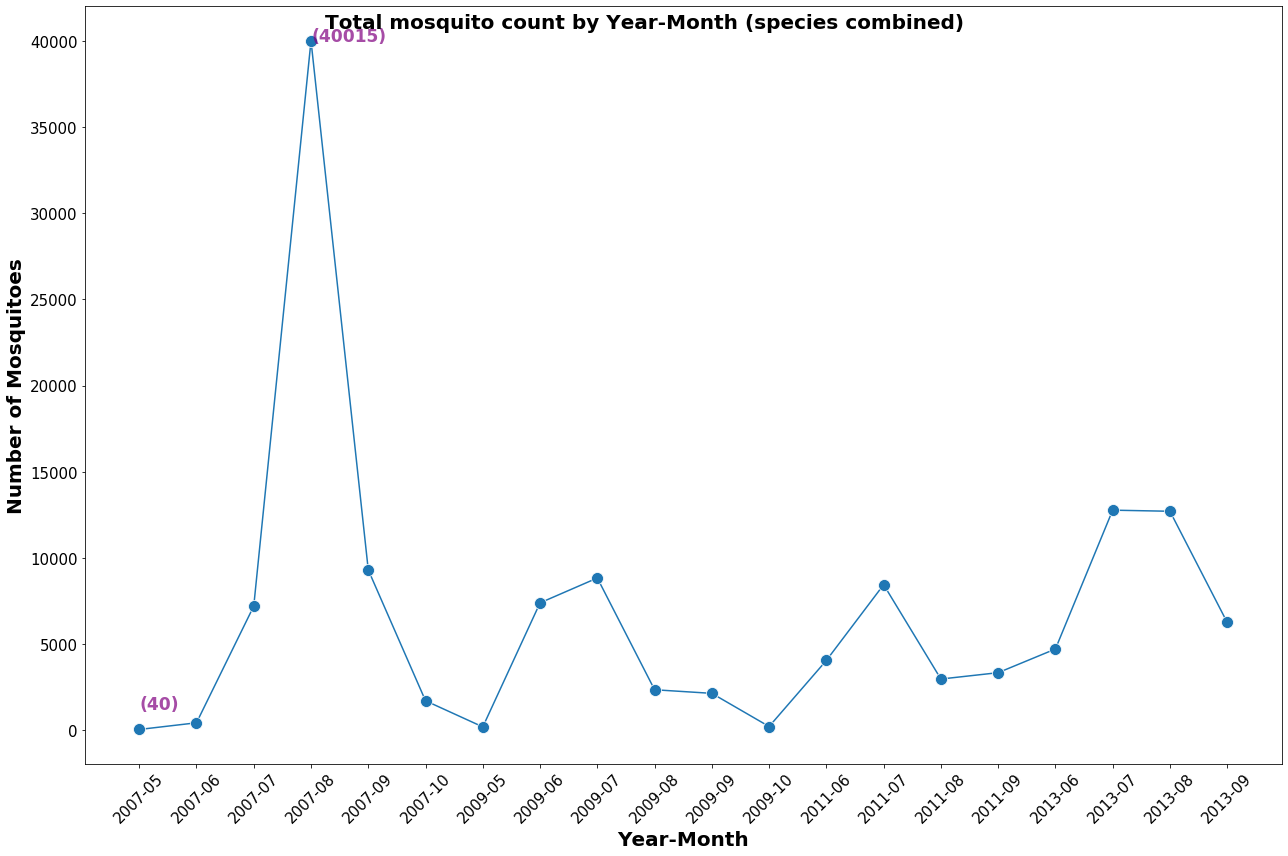

In [47]:
# plotting total number of mosquitos per month

temp_df = g_train.groupby(["yearmonth"]).sum()

plt.figure(figsize=(18,12))

sns.lineplot(x = temp_df.index,y = temp_df['NumMosquitos'], marker='o', markersize=12 )

plt.xlabel('Year-Month', fontweight='bold', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=45)

# to annotate the very first value
first_yearmonth = temp_df.sort_values(by="yearmonth", ascending=True).index[0]
first_val = temp_df.sort_values(by="yearmonth", ascending=True)["NumMosquitos"][0]
plt.text(x = first_yearmonth, y=1200, s="(" + str(first_val) + ")", alpha=0.7, color='purple', fontsize = "17", fontweight="bold")

# to annotate the peak value
max_yearmonth = temp_df.sort_values(by="NumMosquitos", ascending=False).index[0]
max_val = temp_df.sort_values(by="NumMosquitos", ascending=False)["NumMosquitos"][0]
plt.text(x=max_yearmonth, y=max_val, s="(" + str(max_val) + ")", alpha=0.7, color='purple', fontsize = "17", fontweight="bold")

title = "Total mosquito count by Year-Month (species combined)"
plt.suptitle(title, fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tight_layout()

plt.savefig(title)

### Total mosquito count by Year-Month (by species)

In [48]:
color_dict = dict({
            'CULEX PIPIENS':'tomato',
            'CULEX PIPIENS/RESTUANS':'orange',
            'CULEX RESTUANS': 'gold',
            'CULEX SALINARIUS': 'wheat',
            'CULEX TERRITANS': 'teal',
            'CULEX TARSALIS' : 'forestgreen',
            'CULEX ERRATICUS': 'dodgerblue'
          })

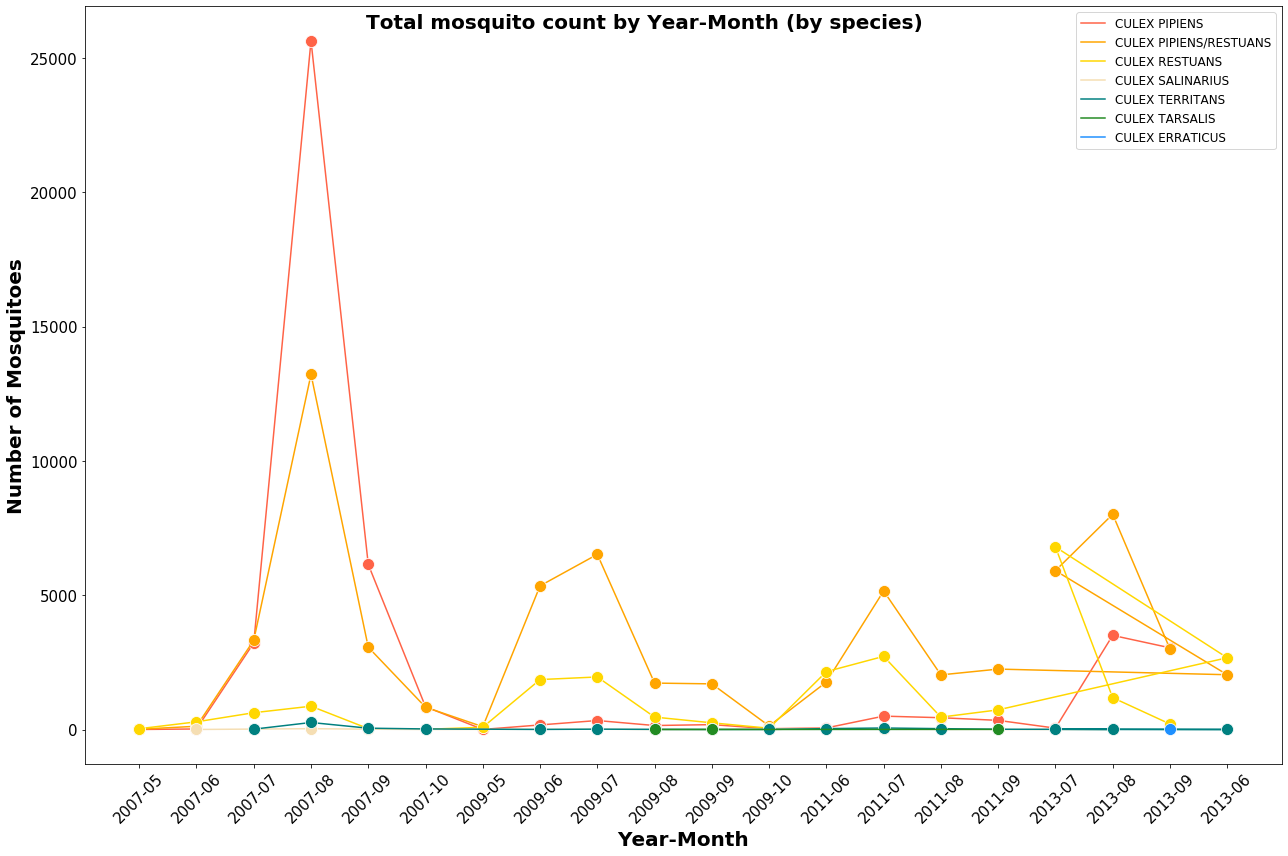

In [49]:
# plotting number of mosquitos per month, segregated by species

# creating a temporary df for our groupby view
temp_df = g_train.groupby(["yearmonth","Species"]).sum()

# since temp_df now is a multi-index df, we need to iterate through the index to pass `YearMonth` and `Species` to the plot  function
x_index = [keys for keys, values in temp_df.index]
hue_index = [values for keys, values in temp_df.index]

plt.figure(figsize=(18,12))

sns.lineplot(x = x_index,y = "NumMosquitos", data =temp_df.sort_index(level=0), marker='o', markersize=12, hue=hue_index, palette=color_dict)


plt.xlabel('Year-Month', fontweight='bold', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=45)

title = "Total mosquito count by Year-Month (by species)"
plt.suptitle(title, fontweight='bold', fontsize='20', horizontalalignment='center')

plt.legend(fontsize='large', title_fontsize='20')


plt.tight_layout()

plt.savefig(title)

### Total mosquito count by Year (by species)

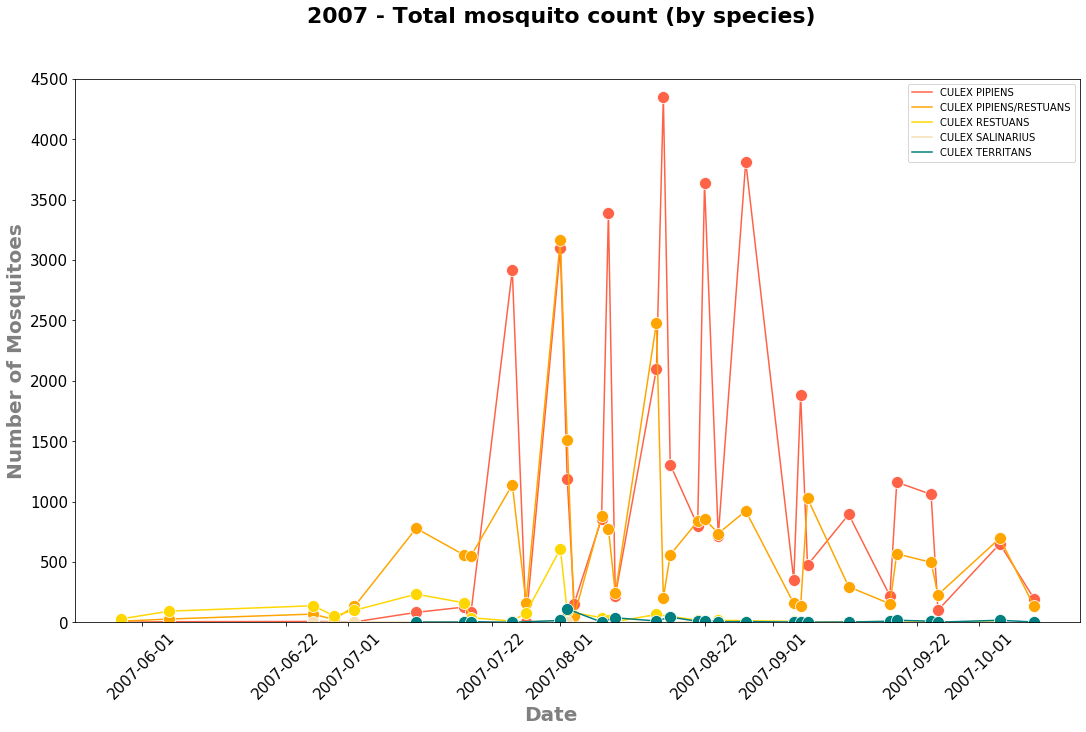

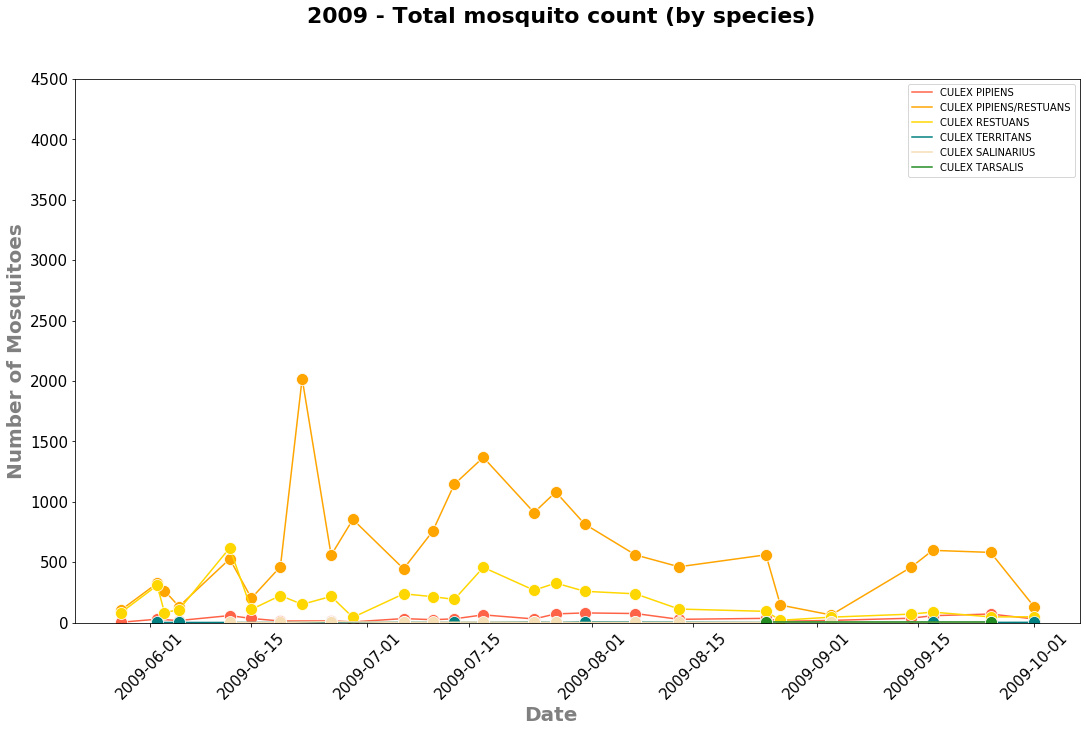

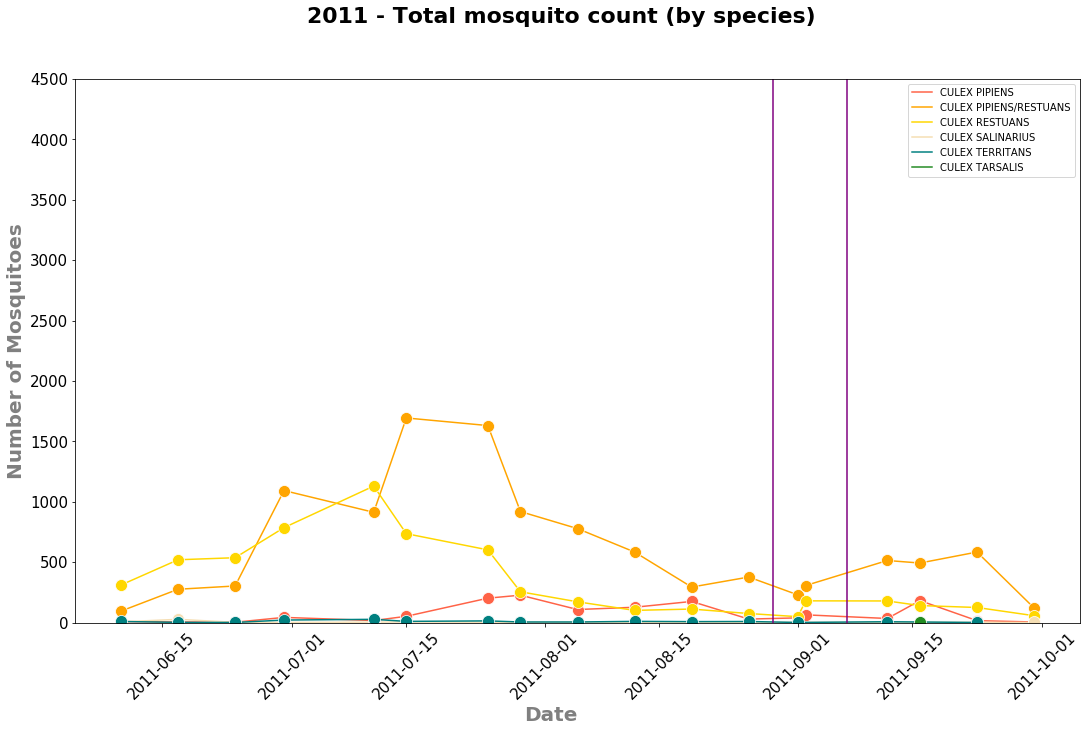

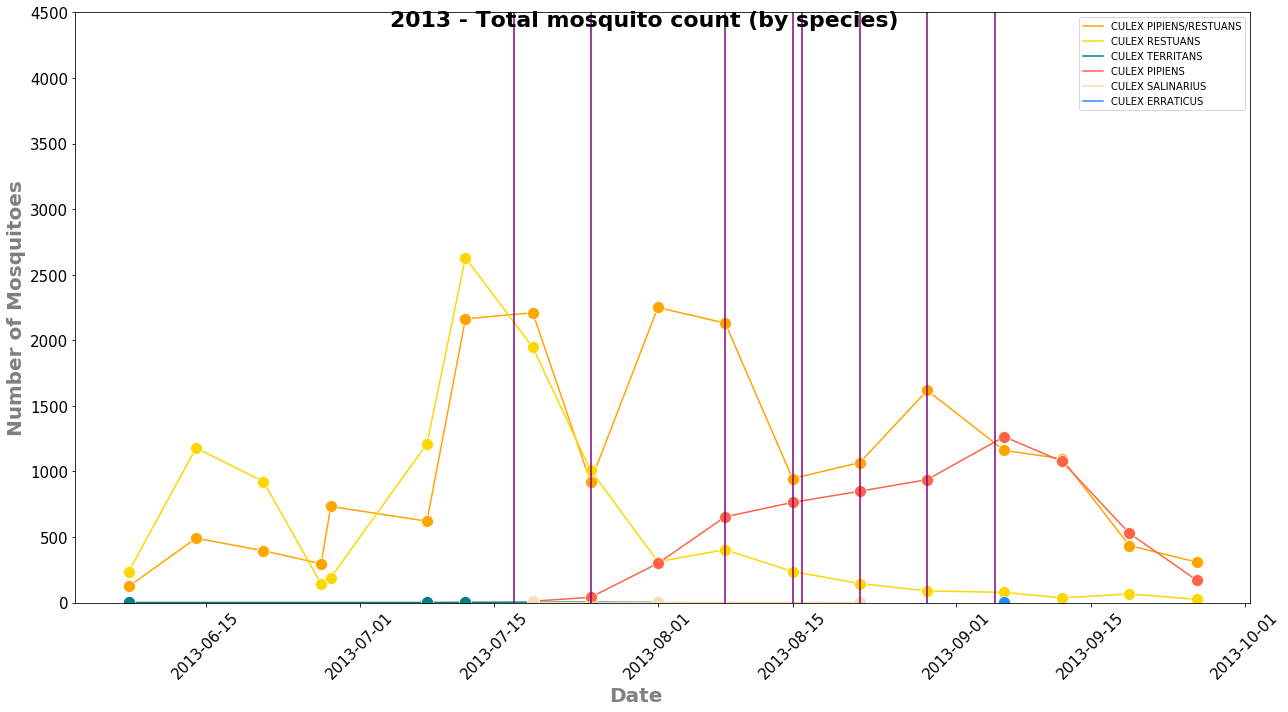

In [50]:
# to show total number of mosquitos per date, segregated by species, with spray dates indicated in purple

for yr in [y for y in g_train['Date'].apply(lambda x: x.year).unique()]:

    # creating a temporary df to show only records for a particular year, grouped by date and species
    temp_df = g_train[g_train["year"] == yr].groupby(["Date", "Species"]).sum()

    # since temp_df now is a multi-index df, we need to iterate through the index 
    # to pass `Date` and `Species` to the plot  function
    date_index = [keys for keys, values in temp_df.index]
    hue_index = [values for keys, values in temp_df.index]
    
    plt.figure(figsize=(18,10))

    sns.lineplot(x = date_index, y = "NumMosquitos", data =temp_df, marker='o', markersize=12, hue=hue_index, palette=color_dict)

    plt.xlabel('Date', fontweight='bold', fontsize='20', horizontalalignment="right", color="gray")
    plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center', color="gray")
    plt.ylim(0, 4500)

    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks(rotation=45)
    
    for sp_date in unique_spray_dates:
        if yr == sp_date.year:
            plt.axvline(sp_date, label="spray", color='purple')
#             plt.text(x=sp_date, y=1200, s=f'{sp_date}', alpha=0.7, color='purple')
        else:
            pass
    
    title = f"{yr} - Total mosquito count (by species)"
    plt.suptitle(title, fontweight='bold', fontsize='22', horizontalalignment='center')

plt.tight_layout()

### Effect of spraying by date and distance

In [51]:
# this function takes in number of days and spray radius
# then charts total number of mosquitoes (per species) 

# `ndays` refers to the number of days to look up. 
# this only works if nearest_spray() has been called to populate relevant data
# `dist_m` refer to the maximum distance (in metres) that the nearest spray site can be from a trap location 
# for the trap to be considered sprayed
# e.g. if `dist_m` is 100, then this function will only consider traps sprayed
# if the nearest site is no more than 100m away


def spray_effect(ndays, dist_m):
    
    col_name = "n" + str(ndays) + "_spray_dist_m"
    
    if col_name in g_train.columns:
    
        days_df = g_train[g_train[col_name].notnull()]
        
        dist_df = days_df[days_df[col_name] <= dist_m]
        
        if dist_df.shape[0] == 0:
            
            return f"Error: No records returned for `ndays` {ndays} and distance {dist_m}m."
        
        else: 
        
            for yr in [y for y in g_train["Year"].unique()]:
                
                if (yr == 2011) or (yr == 2013):
                    
                    # creating a temporary df to show only records for a particular year, grouped by date and species
                    temp_df = dist_df[dist_df["Year"] == yr].groupby(["Date", "Species"]).sum()

                    # since temp_df now is a multi-index df, we need to iterate through the index 
                    # to pass `Date` and `Species` to the plot  function
                    date_index = [keys for keys, values in temp_df.index]
                    hue_index = [values for keys, values in temp_df.index]

                    plt.figure(figsize=(18,12))

                    sns.lineplot(x = date_index, y = "NumMosquitos", data =temp_df, marker='o', markersize=12, hue=hue_index, palette=color_dict)


                    plt.xlabel('Date', fontweight='bold', fontsize='20', horizontalalignment="right", color="gray")
                    plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center', color="gray")
    #                 plt.ylim(0, 4500)

                    plt.tick_params(axis='both', which='major', labelsize=15)
                    plt.xticks(rotation=45)


                    for sp_date in unique_spray_dates:
                        if yr == sp_date.year:
                            plt.axvline(sp_date, label="spray", color='purple')
                #             plt.text(x=sp_date, y=1200, s=f'{sp_date}', alpha=0.7, color='purple')
                
        
                        else:
                            pass


                    chart_title = f"{yr} - Total mosquito count (by species)\nrange = {ndays} days, {dist_m}m"
                    plt.suptitle(chart_title, fontweight='bold', fontsize='22', horizontalalignment='center')


                    plt.tight_layout()

                    image_title = f"n{ndays}_{dist_m}m - {yr} - Total moz (by species)"
                    plt.savefig(image_title)
                    
                
                    display(temp_df)
                    
                else:
                    pass

                
    else:
        
        return f"Error: Data for `ndays` = {ndays} not in table"

Block   Latitude  Longitude  \
Date       Species                                               
2011-09-12 CULEX PIPIENS/RESTUANS     51  41.973845 -87.805059   
           CULEX RESTUANS             51  41.973845 -87.805059   
2011-09-16 CULEX PIPIENS/RESTUANS     51  41.973845 -87.805059   
           CULEX RESTUANS             51  41.973845 -87.805059   

                                   AddressAccuracy  WnvPresent  year  month  \
Date       Species                                                            
2011-09-12 CULEX PIPIENS/RESTUANS                9           0  2011      9   
           CULEX RESTUANS                        9           0  2011      9   
2011-09-16 CULEX PIPIENS/RESTUANS                9           0  2011      9   
           CULEX RESTUANS                        9           0  2011      9   

                                   weekofyear  NumMosquitos  Year  Month  Day  \
Date       Species                                                              
2011-09-12 CULEX PIPIENS/RESTUANS          37             8  2011      9   12   
           CULEX RESTUANS                  37             2  2011      9   12   
2011-09-16 CULEX PIPIENS/RESTUANS          37             9  2011      9   16   
           CULEX RESTUANS                  37             7  2011      9   16   

                                   Week  n3_spray_dist_deg  n3_spray_dist_m  \
Date       Species                                                            
2011-09-12 CULEX PIPIENS/RESTUANS    37                0.0              0.0   
           CULEX RESTUANS            37                0.0              0.0   
2011-09-16 CULEX PIPIENS/RESTUANS    37                0.0              0.0   
           CULEX RESTUANS            37                0.0              0.0   

                                   n7_spray_dist_deg  n7_spray_dist_m  \
Date       Species                                                      
2011-09-12 CULEX PIPIENS/RESTUANS           0.000304        26.200614   
           CULEX RESTUANS                   0.000304        26.200614   
2011-09-16 CULEX PIPIENS/RESTUANS           0.000000         0.000000   
           CULEX RESTUANS                   0.000000         0.000000   

                                   n14_spray_dist_deg  n14_spray_dist_m  
Date       Species                                                       
2011-09-12 CULEX PIPIENS/RESTUANS            0.000304         26.200614  
           CULEX RESTUANS                    0.000304         26.200614  
2011-09-16 CULEX PIPIENS/RESTUANS            0.000304         26.200614  
           CULEX RESTUANS                    0.000304         26.200614

Block    Latitude   Longitude  \
Date       Species                                                 
2013-07-19 CULEX PIPIENS/RESTUANS    256  209.193655 -438.521468   
           CULEX RESTUANS            248  209.180020 -438.514446   
2013-07-25 CULEX PIPIENS/RESTUANS    287  251.131886 -526.239503   
           CULEX RESTUANS            186  167.185341 -350.743547   
2013-08-01 CULEX PIPIENS              39   41.951866  -87.725057   
           CULEX PIPIENS/RESTUANS     39   41.951866  -87.725057   
           CULEX RESTUANS             39   41.951866  -87.725057   
           CULEX TERRITANS            39   41.951866  -87.725057   
2013-08-08 CULEX PIPIENS              28   41.932094  -87.700117   
2013-08-15 CULEX PIPIENS             111   83.870955 -175.601506   
           CULEX PIPIENS/RESTUANS    213  209.630981 -438.843066   
           CULEX RESTUANS             41   41.954690  -87.800991   
2013-08-22 CULEX PIPIENS             343  334.690935 -701.500075   
           CULEX PIPIENS/RESTUANS    340  376.764191 -789.428596   
           CULEX RESTUANS            216  209.194193 -438.488967   
2013-08-29 CULEX PIPIENS             153  209.091609 -438.198236   
           CULEX PIPIENS/RESTUANS    330  251.187618 -526.034415   
           CULEX RESTUANS            116   83.974201 -175.355844   
2013-09-06 CULEX PIPIENS             196  125.768816 -263.176390   
           CULEX PIPIENS/RESTUANS    196  125.768816 -263.176390   
2013-09-12 CULEX PIPIENS              71   42.009876  -87.807277   
           CULEX PIPIENS/RESTUANS     71   42.009876  -87.807277   

                                   AddressAccuracy  WnvPresent   year  month  \
Date       Species                                                             
2013-07-19 CULEX PIPIENS/RESTUANS               40           1  10065     35   
           CULEX RESTUANS                       39           0  10065     35   
2013-07-25 CULEX PIPIENS/RESTUANS               47           0  12078     42   
           CULEX RESTUANS                       31           0   8052     28   
2013-08-01 CULEX PIPIENS                         8           0   2013      8   
           CULEX PIPIENS/RESTUANS                8           0   2013      8   
           CULEX RESTUANS                        8           0   2013      8   
           CULEX TERRITANS                       8           0   2013      8   
2013-08-08 CULEX PIPIENS                         8           0   2013      8   
2013-08-15 CULEX PIPIENS                        17           1   4026     16   
           CULEX PIPIENS/RESTUANS               43           2  10065     40   
           CULEX RESTUANS                        9           0   2013      8   
2013-08-22 CULEX PIPIENS                        59           2  16104     64   
           CULEX PIPIENS/RESTUANS               68           2  18117     72   
           CULEX RESTUANS                       36           0  10065     40   
2013-08-29 CULEX PIPIENS                        33           1  10065     40   
           CULEX PIPIENS/RESTUANS               48           1  12078     48   
           CULEX RESTUANS                       17           0   4026     16   
2013-09-06 CULEX PIPIENS                        25           1   6039     27   
           CULEX PIPIENS/RESTUANS               25           1   6039     27   
2013-09-12 CULEX PIPIENS                         9           0   2013      9   
           CULEX PIPIENS/RESTUANS                9           0   2013      9   

                                   weekofyear  NumMosquitos   Year  Month  \
Date       Species                                                          
2013-07-19 CULEX PIPIENS/RESTUANS         145           190  10065     35   
           CULEX RESTUANS                 145           177  10065     35   
2013-07-25 CULEX PIPIENS/RESTUANS         180           153  12078     42   
           CULEX RESTUANS                 120            97   8052     28   
2013-08-01 CULEX PI

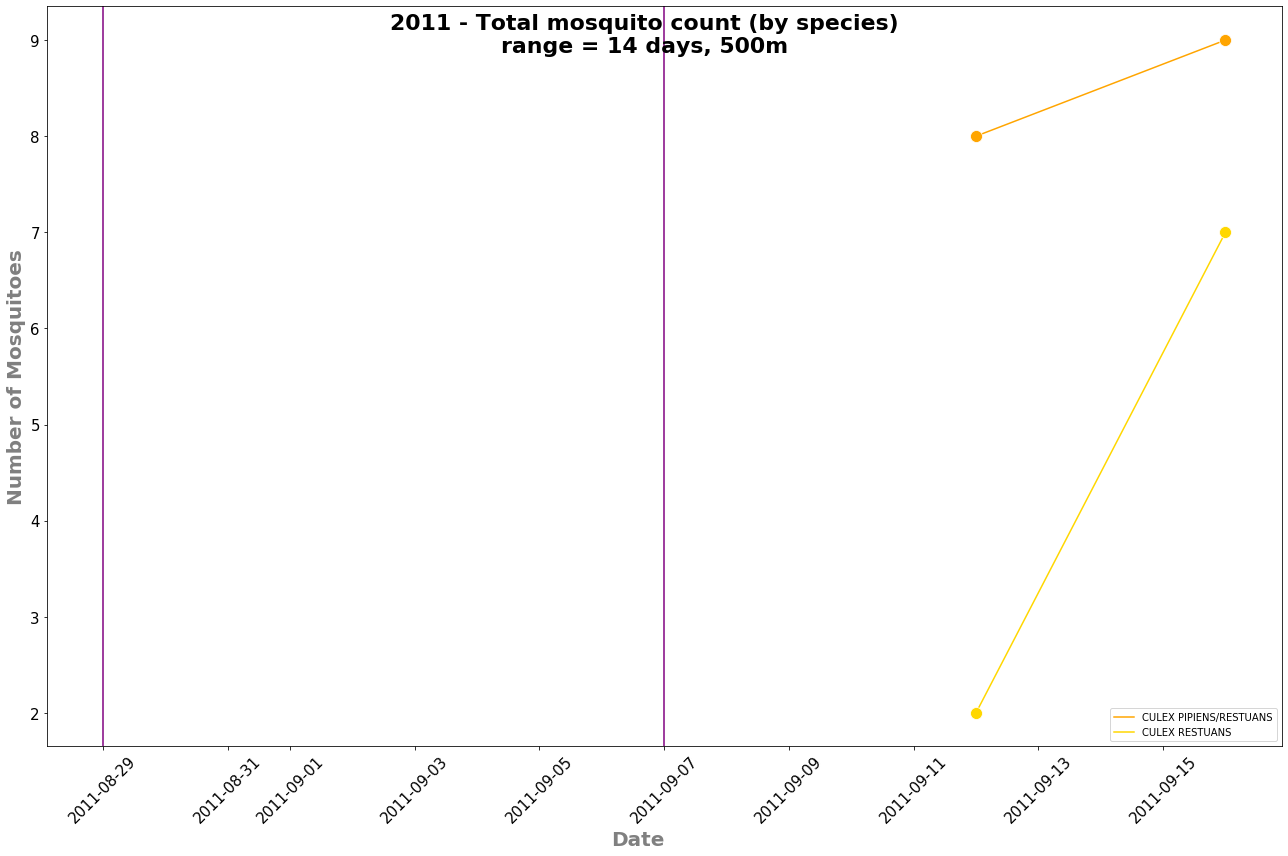

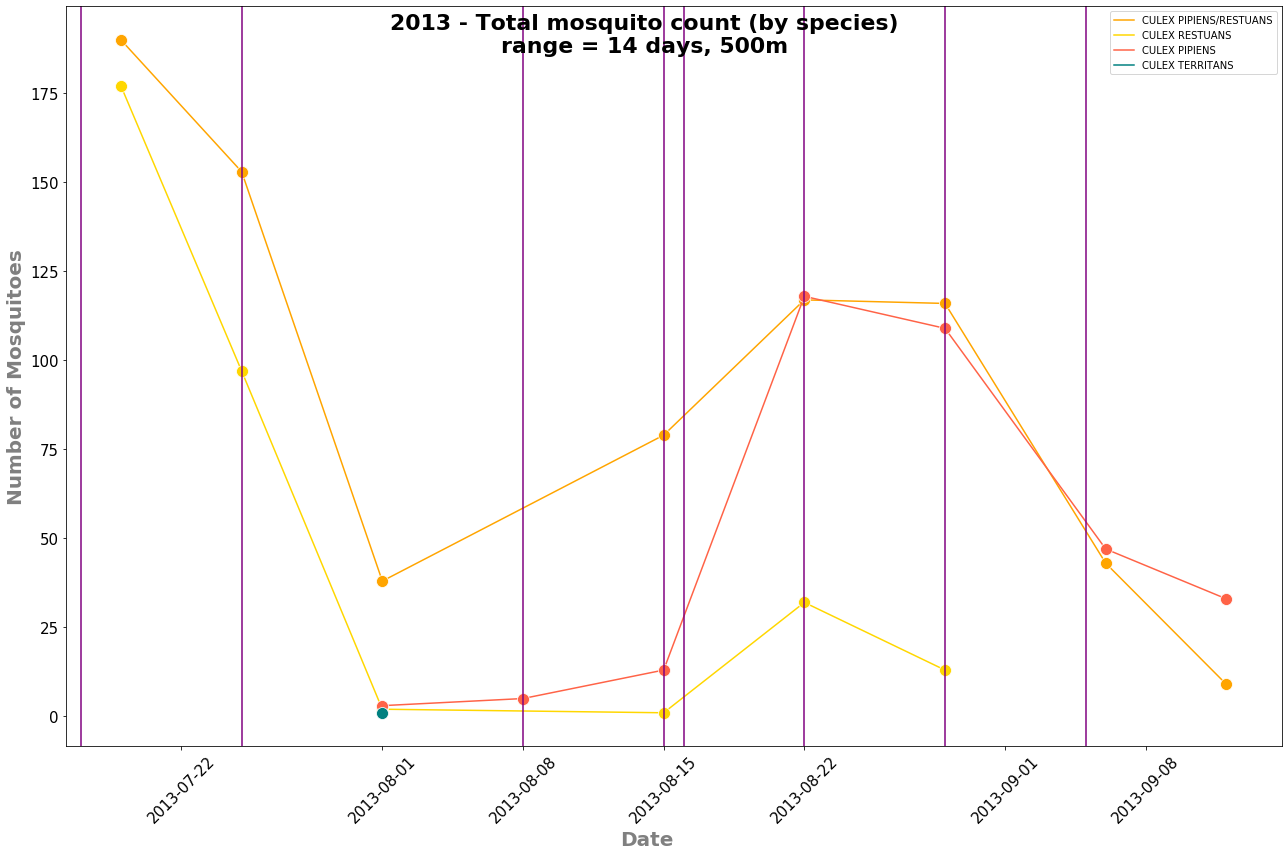

In [52]:
spray_effect(14, 500)

Block   Latitude  Longitude  \
Date       Species                                               
2011-09-12 CULEX PIPIENS/RESTUANS     51  41.973845 -87.805059   
           CULEX RESTUANS             51  41.973845 -87.805059   

                                   AddressAccuracy  WnvPresent  year  month  \
Date       Species                                                            
2011-09-12 CULEX PIPIENS/RESTUANS                9           0  2011      9   
           CULEX RESTUANS                        9           0  2011      9   

                                   weekofyear  NumMosquitos  Year  Month  Day  \
Date       Species                                                              
2011-09-12 CULEX PIPIENS/RESTUANS          37             8  2011      9   12   
           CULEX RESTUANS                  37             2  2011      9   12   

                                   Week  n3_spray_dist_deg  n3_spray_dist_m  \
Date       Species                                                            
2011-09-12 CULEX PIPIENS/RESTUANS    37                0.0              0.0   
           CULEX RESTUANS            37                0.0              0.0   

                                   n7_spray_dist_deg  n7_spray_dist_m  \
Date       Species                                                      
2011-09-12 CULEX PIPIENS/RESTUANS           0.000304        26.200614   
           CULEX RESTUANS                   0.000304        26.200614   

                                   n14_spray_dist_deg  n14_spray_dist_m  
Date       Species                                                       
2011-09-12 CULEX PIPIENS/RESTUANS            0.000304         26.200614  
           CULEX RESTUANS                    0.000304         26.200614

Block    Latitude   Longitude  \
Date       Species                                                 
2013-07-19 CULEX PIPIENS/RESTUANS    256  209.193655 -438.521468   
           CULEX RESTUANS            248  209.180020 -438.514446   
2013-07-25 CULEX PIPIENS/RESTUANS     39   41.951866  -87.725057   
2013-08-08 CULEX PIPIENS              28   41.932094  -87.700117   
2013-08-15 CULEX PIPIENS             111   83.870955 -175.601506   
           CULEX PIPIENS/RESTUANS    185  167.698887 -351.142949   
           CULEX RESTUANS             41   41.954690  -87.800991   
2013-08-22 CULEX PIPIENS             232  250.819980 -525.898569   
           CULEX PIPIENS/RESTUANS    155  209.065304 -438.285647   
           CULEX RESTUANS             85  125.354190 -262.903164   
2013-08-29 CULEX PIPIENS              58   41.986921  -87.689778   
           CULEX PIPIENS/RESTUANS    183  125.745861 -263.058891   
           CULEX RESTUANS            116   83.974201 -175.355844   
2013-09-06 CULEX PIPIENS              71   42.009876  -87.807277   
           CULEX PIPIENS/RESTUANS     71   42.009876  -87.807277   

                                   AddressAccuracy  WnvPresent   year  month  \
Date       Species                                                             
2013-07-19 CULEX PIPIENS/RESTUANS               40           1  10065     35   
           CULEX RESTUANS                       39           0  10065     35   
2013-07-25 CULEX PIPIENS/RESTUANS                8           0   2013      7   
2013-08-08 CULEX PIPIENS                         8           0   2013      8   
2013-08-15 CULEX PIPIENS                        17           1   4026     16   
           CULEX PIPIENS/RESTUANS               35           2   8052     32   
           CULEX RESTUANS                        9           0   2013      8   
2013-08-22 CULEX PIPIENS                        42           1  12078     48   
           CULEX PIPIENS/RESTUANS               33           1  10065     40   
           CULEX RESTUANS                       19           0   6039     24   
2013-08-29 CULEX PIPIENS                         9           1   2013      8   
           CULEX PIPIENS/RESTUANS               25           1   6039     24   
           CULEX RESTUANS                       17           0   4026     16   
2013-09-06 CULEX PIPIENS                         9           1   2013      9   
           CULEX PIPIENS/RESTUANS                9           1   2013      9   

                                   weekofyear  NumMosquitos   Year  Month  \
Date       Species                                                          
2013-07-19 CULEX PIPIENS/RESTUANS         145           190  10065     35   
           CULEX RESTUANS                 145           177  10065     35   
2013-07-25 CULEX PIPIENS/RESTUANS          30            24   2013      7   
2013-08-08 CULEX PIPIENS                   32             5   2013      8   
2013-08-15 CULEX PIPIENS                   66            13   4026     16   
           CULEX PIPIENS/RESTUANS         132            72   8052     32   
           CULEX RESTUANS                  33             1   2013      8   
2013-08-22 CULEX PIPIENS                  204            96  12078     48   
           CULEX PIPIENS/RESTUANS         170            63  10065     40   
           CULEX RESTUANS                 102            26   6039     24   
2013-08-29 CULEX PIPIENS                   35            17   2013      8   
           CULEX PIPIENS/RESTUANS         105            93   6039     24   
           CULEX RESTUANS                  70            13   4026     16   
2013-09-06 CULEX PIPIENS                   36            18   2013      9   
           CULEX PIPIENS/RESTUANS          36            15   2013      9   

                                   Day  Week  n3_spray_dist_deg  \
Date       Species                                                
2013-07-19 CULEX PIPIENS/RESTUANS   95   145           0.005433   
      

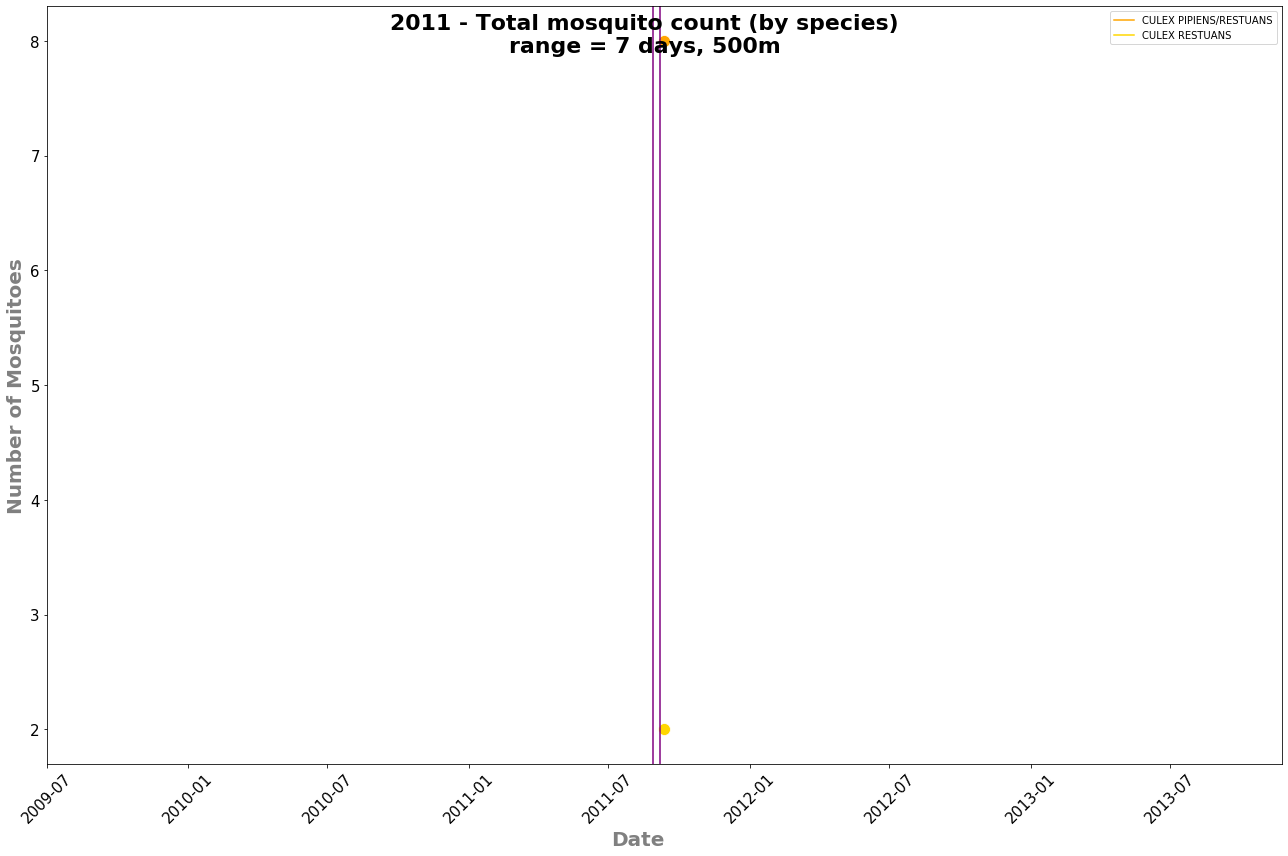

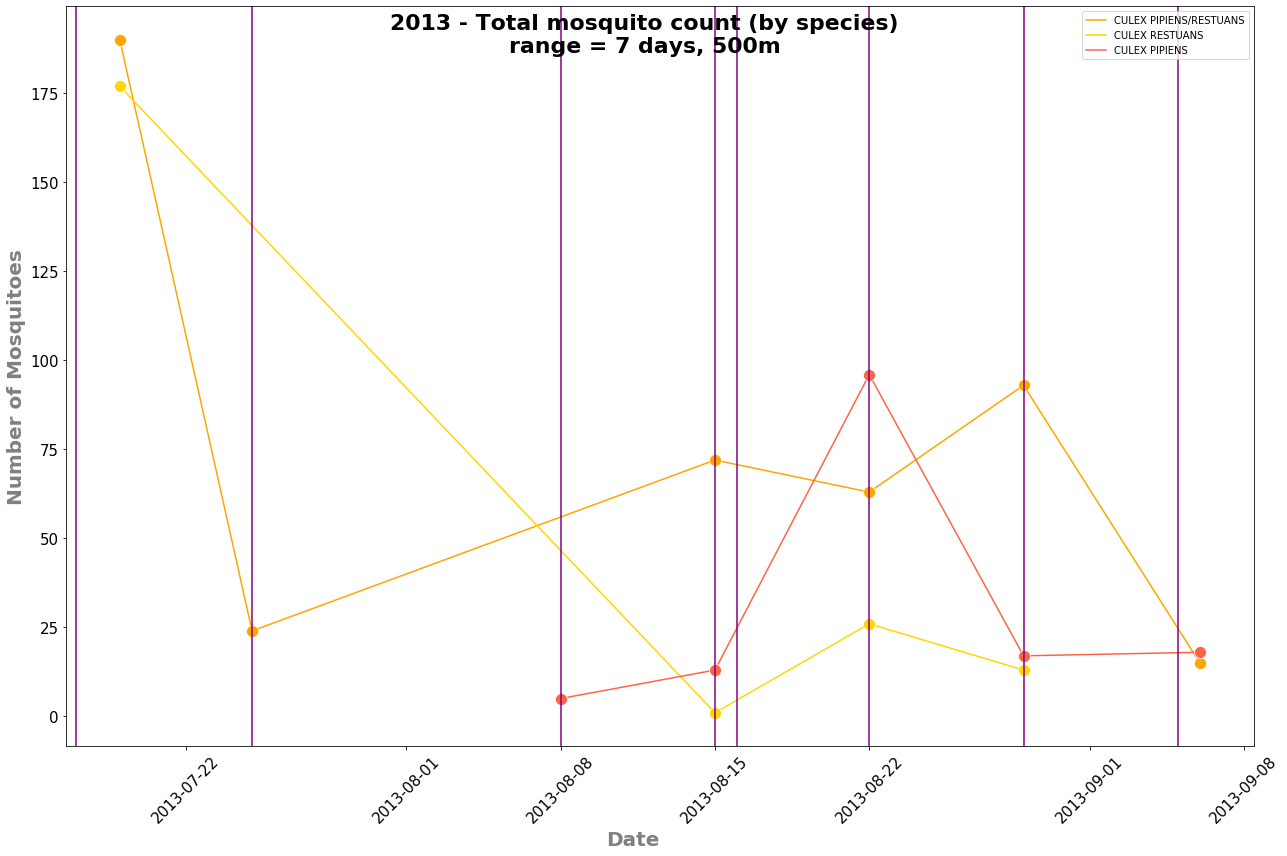

In [53]:
spray_effect(7, 500)

Empty DataFrame
Columns: [Block, Latitude, Longitude, AddressAccuracy, WnvPresent, year, month, weekofyear, NumMosquitos, Year, Month, Day, Week, n3_spray_dist_deg, n3_spray_dist_m, n7_spray_dist_deg, n7_spray_dist_m, n14_spray_dist_deg, n14_spray_dist_m]
Index: []

Block    Latitude   Longitude  \
Date       Species                                                 
2013-07-19 CULEX PIPIENS/RESTUANS    256  209.193655 -438.521468   
           CULEX RESTUANS            248  209.180020 -438.514446   
2013-07-25 CULEX PIPIENS/RESTUANS     39   41.951866  -87.725057   
2013-08-08 CULEX PIPIENS              28   41.932094  -87.700117   
2013-08-15 CULEX PIPIENS             111   83.870955 -175.601506   
           CULEX PIPIENS/RESTUANS    185  167.698887 -351.142949   
           CULEX RESTUANS             41   41.954690  -87.800991   
2013-08-22 CULEX PIPIENS             172  208.859364 -438.121380   
           CULEX PIPIENS/RESTUANS     95  167.104688 -350.508458   
           CULEX RESTUANS             85  125.354190 -262.903164   
2013-08-29 CULEX PIPIENS              58   41.986921  -87.689778   
           CULEX PIPIENS/RESTUANS    183  125.745861 -263.058891   
           CULEX RESTUANS            116   83.974201 -175.355844   
2013-09-06 CULEX PIPIENS              71   42.009876  -87.807277   
           CULEX PIPIENS/RESTUANS     71   42.009876  -87.807277   

                                   AddressAccuracy  WnvPresent   year  month  \
Date       Species                                                             
2013-07-19 CULEX PIPIENS/RESTUANS               40           1  10065     35   
           CULEX RESTUANS                       39           0  10065     35   
2013-07-25 CULEX PIPIENS/RESTUANS                8           0   2013      7   
2013-08-08 CULEX PIPIENS                         8           0   2013      8   
2013-08-15 CULEX PIPIENS                        17           1   4026     16   
           CULEX PIPIENS/RESTUANS               35           2   8052     32   
           CULEX RESTUANS                        9           0   2013      8   
2013-08-22 CULEX PIPIENS                        33           1  10065     40   
           CULEX PIPIENS/RESTUANS               24           1   8052     32   
           CULEX RESTUANS                       19           0   6039     24   
2013-08-29 CULEX PIPIENS                         9           1   2013      8   
           CULEX PIPIENS/RESTUANS               25           1   6039     24   
           CULEX RESTUANS                       17           0   4026     16   
2013-09-06 CULEX PIPIENS                         9           1   2013      9   
           CULEX PIPIENS/RESTUANS                9           1   2013      9   

                                   weekofyear  NumMosquitos   Year  Month  \
Date       Species                                                          
2013-07-19 CULEX PIPIENS/RESTUANS         145           190  10065     35   
           CULEX RESTUANS                 145           177  10065     35   
2013-07-25 CULEX PIPIENS/RESTUANS          30            24   2013      7   
2013-08-08 CULEX PIPIENS                   32             5   2013      8   
2013-08-15 CULEX PIPIENS                   66            13   4026     16   
           CULEX PIPIENS/RESTUANS         132            72   8052     32   
           CULEX RESTUANS                  33             1   2013      8   
2013-08-22 CULEX PIPIENS                  170            92  10065     40   
           CULEX PIPIENS/RESTUANS         136            58   8052     32   
           CULEX RESTUANS                 102            26   6039     24   
2013-08-29 CULEX PIPIENS                   35            17   2013      8   
           CULEX PIPIENS/RESTUANS         105            93   6039     24   
           CULEX RESTUANS                  70            13   4026     16   
2013-09-06 CULEX PIPIENS                   36            18   2013      9   
           CULEX PIPIENS/RESTUANS          36            15   2013      9   

                                   Day  Week  n3_spray_dist_deg  \
Date       Species                                                
2013-07-19 CULEX PIPIENS/RESTUANS   95   145           0.005433   
      

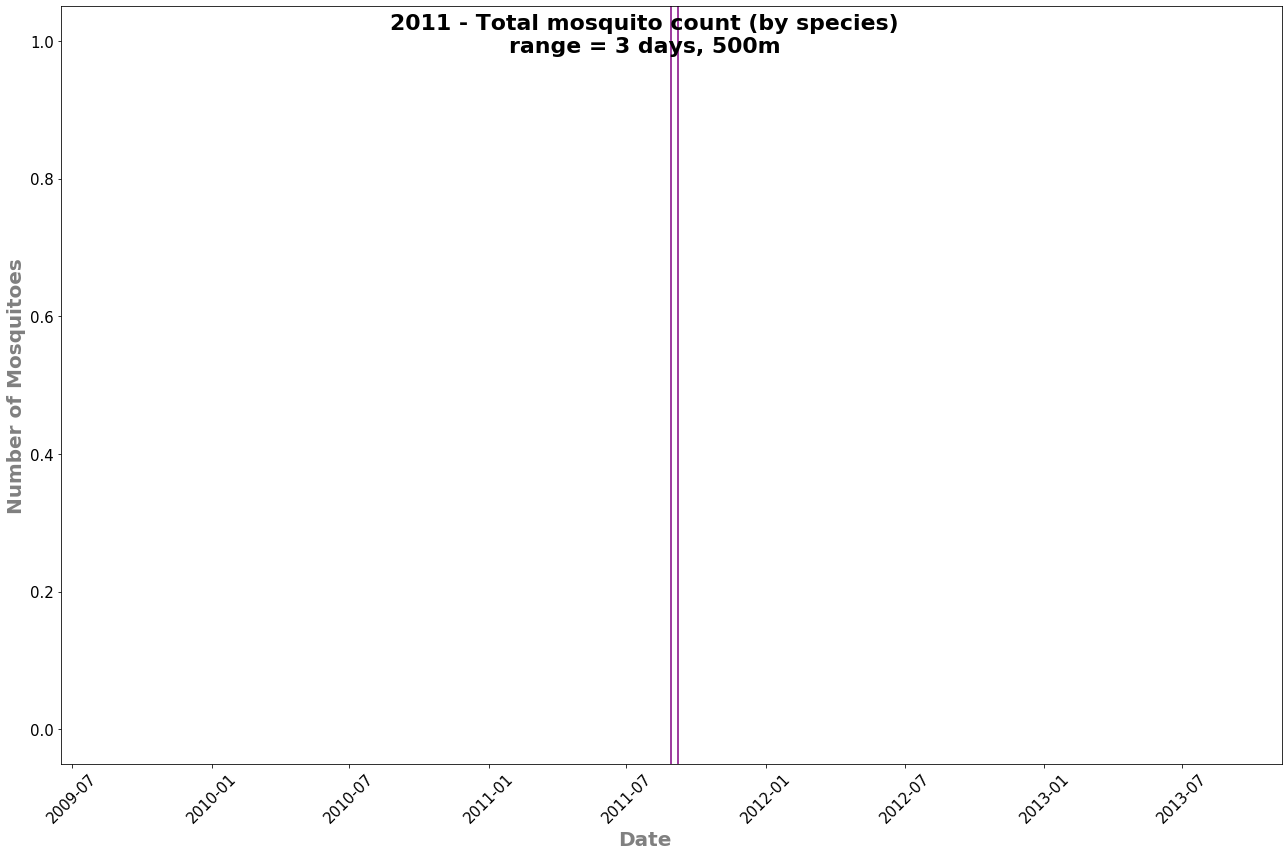

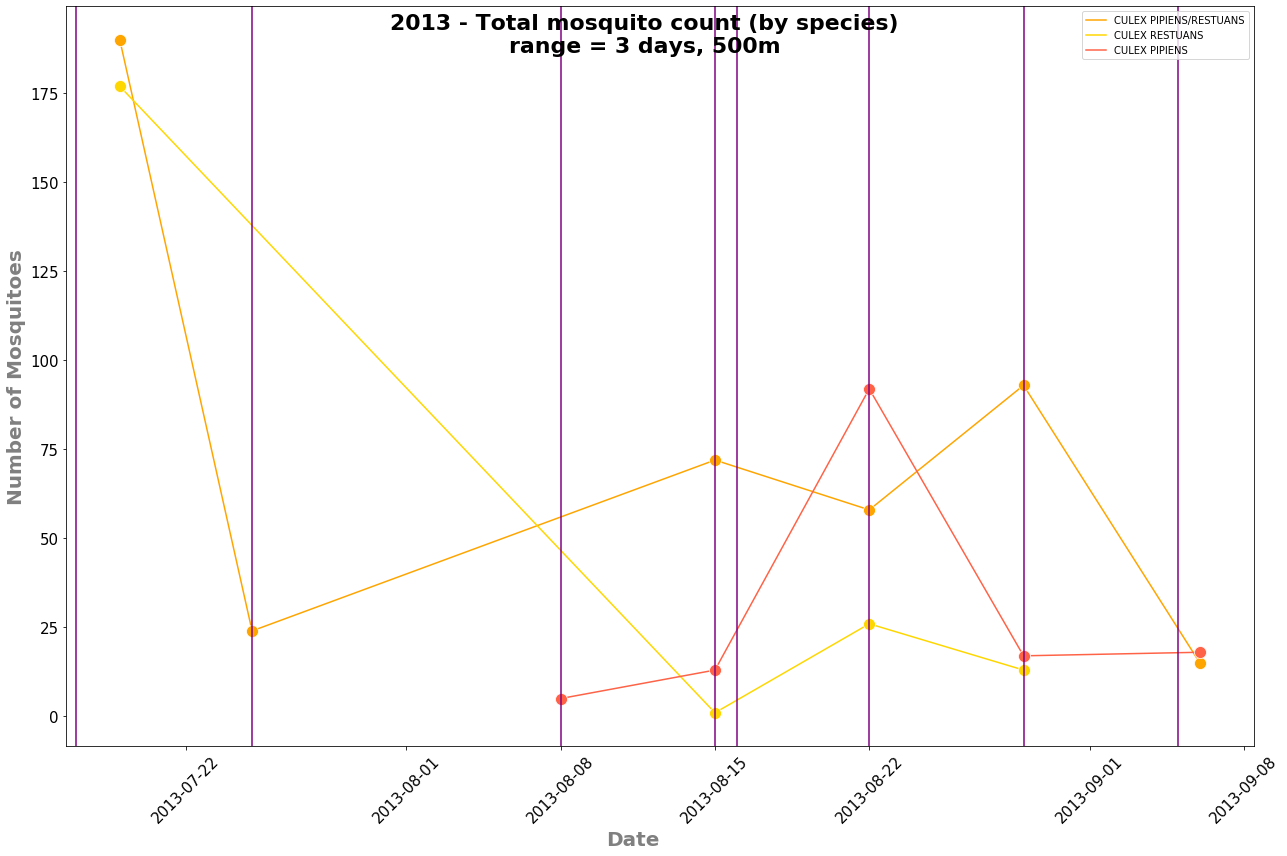

In [54]:
spray_effect(3, 500)

Empty DataFrame
Columns: [Block, Latitude, Longitude, AddressAccuracy, WnvPresent, year, month, weekofyear, NumMosquitos, Year, Month, Day, Week, n3_spray_dist_deg, n3_spray_dist_m, n7_spray_dist_deg, n7_spray_dist_m, n14_spray_dist_deg, n14_spray_dist_m]
Index: []

Block    Latitude   Longitude  \
Date       Species                                                 
2013-07-19 CULEX PIPIENS/RESTUANS    239  167.472807 -350.855454   
           CULEX RESTUANS            169  125.464493 -263.077533   
2013-07-25 CULEX PIPIENS/RESTUANS     39   41.951866  -87.725057   
2013-08-08 CULEX PIPIENS              28   41.932094  -87.700117   
2013-08-15 CULEX PIPIENS              70   41.916265  -87.800515   
           CULEX PIPIENS/RESTUANS     83   83.820459 -175.556670   
2013-08-29 CULEX PIPIENS              58   41.986921  -87.689778   
           CULEX PIPIENS/RESTUANS     58   41.986921  -87.689778   
           CULEX RESTUANS             58   41.986921  -87.689778   
2013-09-06 CULEX PIPIENS              71   42.009876  -87.807277   
           CULEX PIPIENS/RESTUANS     71   42.009876  -87.807277   

                                   AddressAccuracy  WnvPresent  year  month  \
Date       Species                                                            
2013-07-19 CULEX PIPIENS/RESTUANS               31           1  8052     28   
           CULEX RESTUANS                       22           0  6039     21   
2013-07-25 CULEX PIPIENS/RESTUANS                8           0  2013      7   
2013-08-08 CULEX PIPIENS                         8           0  2013      8   
2013-08-15 CULEX PIPIENS                         8           1  2013      8   
           CULEX PIPIENS/RESTUANS               17           1  4026     16   
2013-08-29 CULEX PIPIENS                         9           1  2013      8   
           CULEX PIPIENS/RESTUANS                9           0  2013      8   
           CULEX RESTUANS                        9           0  2013      8   
2013-09-06 CULEX PIPIENS                         9           1  2013      9   
           CULEX PIPIENS/RESTUANS                9           1  2013      9   

                                   weekofyear  NumMosquitos  Year  Month  Day  \
Date       Species                                                              
2013-07-19 CULEX PIPIENS/RESTUANS         116           174  8052     28   76   
           CULEX RESTUANS                  87           162  6039     21   57   
2013-07-25 CULEX PIPIENS/RESTUANS          30            24  2013      7   25   
2013-08-08 CULEX PIPIENS                   32             5  2013      8    8   
2013-08-15 CULEX PIPIENS                   33             9  2013      8   15   
           CULEX PIPIENS/RESTUANS          66            26  4026     16   30   
2013-08-29 CULEX PIPIENS                   35            17  2013      8   29   
           CULEX PIPIENS/RESTUANS          35             3  2013      8   29   
           CULEX RESTUANS                  35             2  2013      8   29   
2013-09-06 CULEX PIPIENS                   36            18  2013      9    6   
           CULEX PIPIENS/RESTUANS          36            15  2013      9    6   

                                   Week  n3_spray_dist_deg  n3_spray_dist_m  \
Date       Species                                                            
2013-07-19 CULEX PIPIENS/RESTUANS   116           0.002177       211.012767   
           CULEX RESTUANS            87           0.001511       144.020663   
2013-07-25 CULEX PIPIENS/RESTUANS    30           0.000037         3.234061   
2013-08-08 CULEX PIPIENS             32           0.000493        53.889275   
2013-08-15 CULEX PIPIENS             33           0.000514        57.033549   
           CULEX PIPIENS/RESTUANS    66           0.000576        63.369325   
2013-08-29 CULEX PIPIENS             35           0.001037        87.513591   
           CULEX PIPIENS/RESTUANS    35           0.001037        87.513591   
           CULEX RESTUANS            35           0.001037        87.513591   
2013-09-06 CULEX PIPIENS             36           0.000499        44.600309   
           CULEX PIPIENS/RESTUANS    36           0.000499        44.600309   

                                   n7_sp

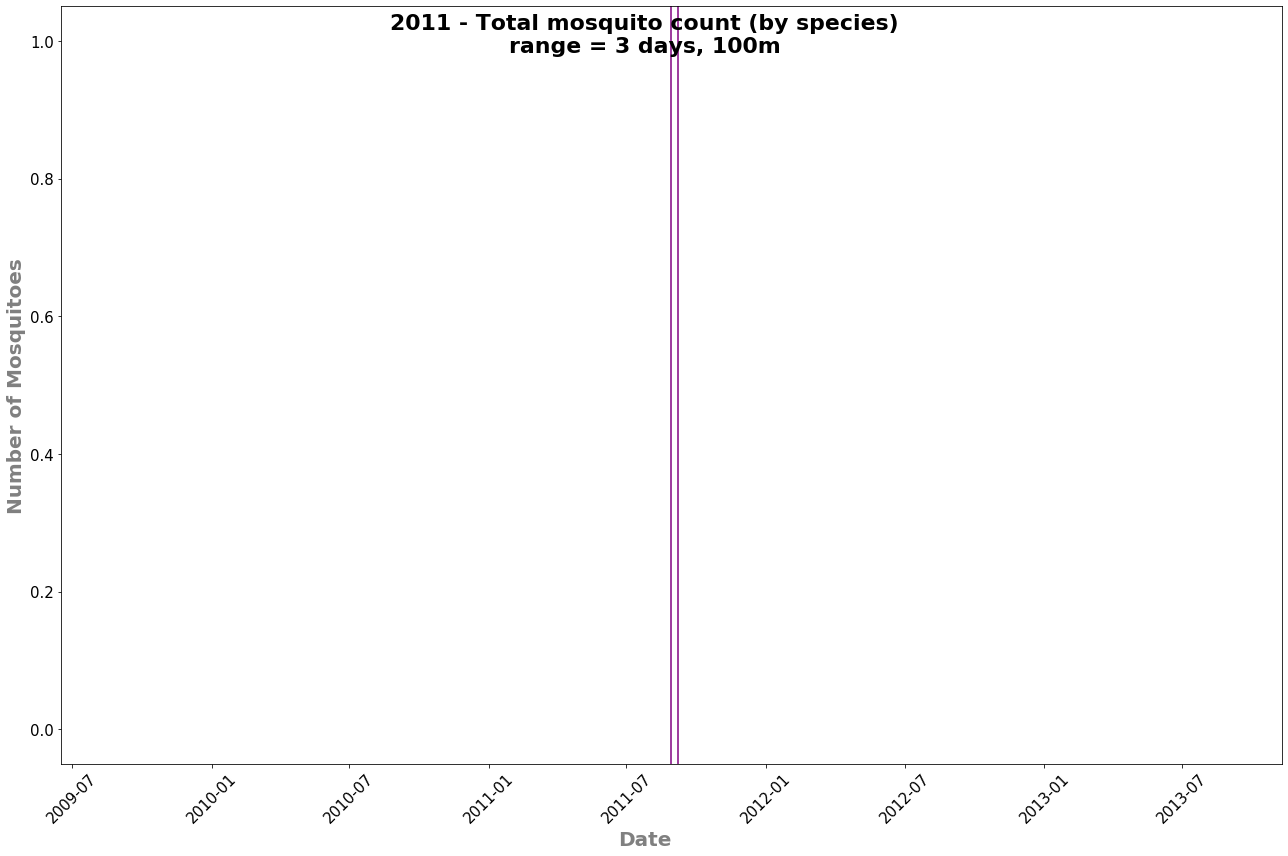

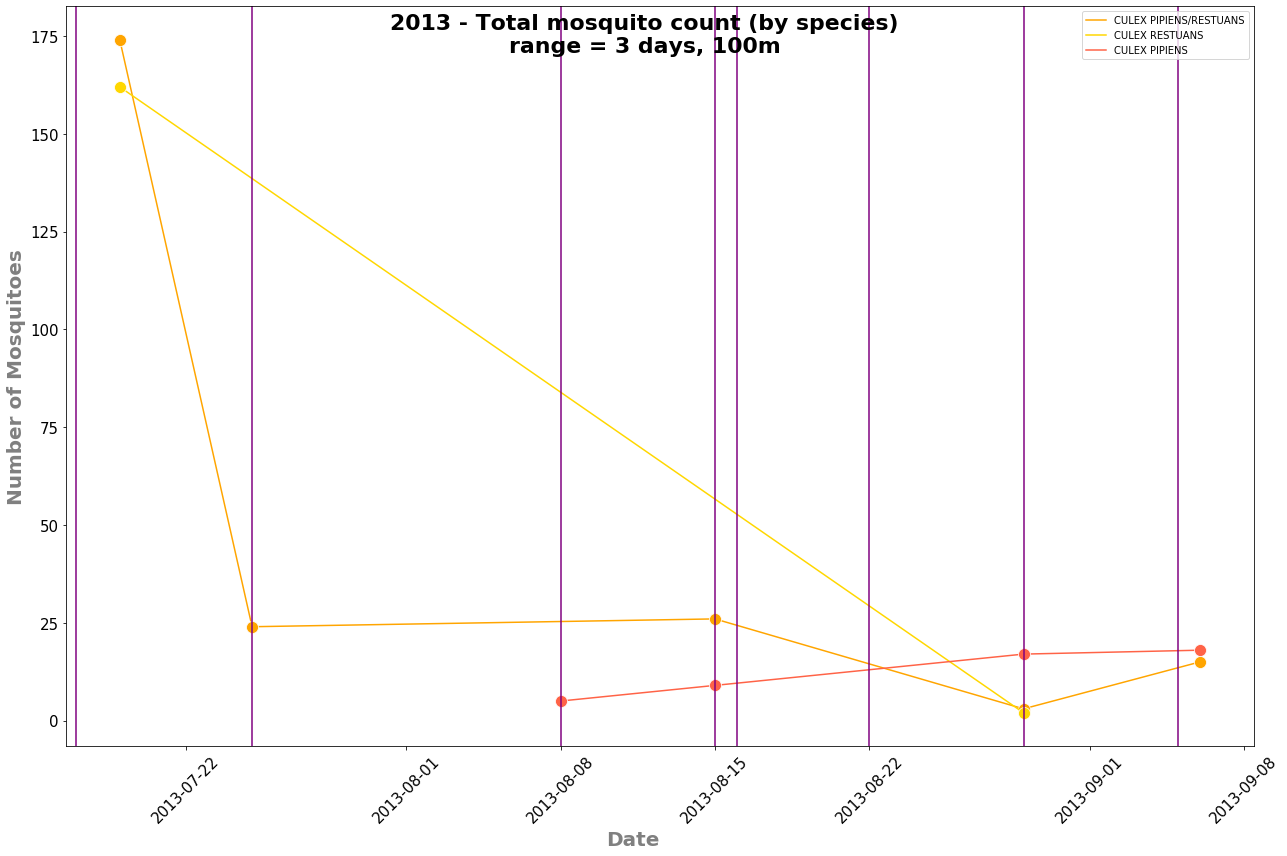

In [55]:
spray_effect(3, 100)

### Conclusion: Relationship between train and spray data

So far we've tried looking at 3-day, 7-day and 14-day ranges with a very generous trap-to-spray distance of 500m. But mosquito count seems to be very erratic. After spraying, sometimes mosquito numbers goes up, and sometimes mosquito numbers go down. This lack of trend suggests that spraying may not have a meaningful impact on mosquito count. 

From research, we know that it takes 10-14 days (weather depending) for mosquito larvae to develop into an adult mosquito. However, since spraying is only useful for killing adult mosquitos, it's not necessary/useful to run this analysis with a date range beyond 14 days.

In addition, given that we only have 10 unique spray dates, there's really not enough data to meaningfully understand the effect of spraying on mosquito population - we cannot determine if this inconclusiveness is because spraying was not effective, or because of issues with the way spraying was carried out. 
From a modeling point of view, the incomplete data makes it difficult to train our model properly. 

Hence, our recommendation - based on the data sets provided - is to turn our attention from spraying to other factors.

## Weather

The weather records provided are between 2007 May and 2014 October. There is a second record everyday as there are 2 weather stations capturing the data each day. From the weather dataset, we are going to focus on variables translating to the optimal condition in the environment for reproduction and they are mainly separated into 2 sections; their habitats and temperature.

Habitat:

Culex mosquitoes breed in various types of stagnant water. Preferred oviposition habitats such as rainwater barrels, catch basins, storm drains, and septic tanks are rich in organic material. Eggs are laid in raft-shaped batches on the water surface.

While Culex will lay their eggs in a variety of standing waters, these habitats can typically be categorized into four ecotypes:

- Sewage Systems
- Container Sources
- Drainage Systems
- Open Habitats

https://www.valentbiosciences.com/publichealth/pests/mosquitoes/mosquitoes-culex/

Temperature:

According to a study conducted on the effects of temperature on the growth and development of Culex pipiens Complex Mosquitoes, it was discovered that varying temperatures were found to have effects on egg embryonation, the lengths of the pupal and larval periods and the survival and longevity of the female mosquitoes.

- In lower temperatures, embryonation took longer among the 20 degree Celsius (68 degree Fahrenheit) and 24 degree Celsius (75.2 degree Fahrenheit) the larval and pupal stages were longer and the female mosquitoes lived longer.
- In higher temperatures, 28 degree Celsius (84.4 degree Fahrenheit), embryonation was faster, the larval and pupal stages were shorter and the females did not live for as long as they did at 20 degree Celsius and 24 degree Celsius.

https://pdfs.semanticscholar.org/1e02/57f23ef925e437a5995c1720b3a2ab518cac.pdf

As such, at first glance, it it likely that the temperature columns "Tmax", "Tmin" and "Tavg" and "PrecipTotal" which indicate the amount of rain will provide the most information on the target.

In [56]:
# date range
weather = pd.read_csv('./assets/weather.csv', parse_dates=['Date'])
print(weather['Date'].max())
print(weather['Date'].min())

weather.head()

2014-10-31 00:00:00
2007-05-01 00:00:00


Station       Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1 2007-05-01    83    50   67     14        51      56    0    2   
1        2 2007-05-01    84    52   68      M        51      57    0    3   
2        1 2007-05-02    59    42   51     -3        42      47   14    0   
3        2 2007-05-02    60    43   52      M        42      47   13    0   
4        1 2007-05-03    66    46   56      2        40      48    9    0   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   
1  ...             M      M        M        0.00       29.18    29.82   
2  ...      BR     0      M      0.0        0.00       29.38    30.09   
3  ...   BR HZ     M      M        M        0.00       29.44    30.08   
4  ...             0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

Traditional techniques will not be able to identify null values as they are being translated into 'M' (according to the data dictionary).

In [57]:
# no nulls but nulls are represented by values like M and -
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(15)
memory usage: 506.1+ KB


### Add dates

Based on the "Date" column, we will create new columns indicating the "year", "month" and the "weekofyear" columns to streamline our EDA. It is important as the data represented only a certain time period within each year;

- year -> 2007 - 2014
- month -> may - oct (corresponding to when traps are deployed)
- weekofyear -> 17 - 44

In [58]:
weather['year'] = weather['Date'].apply(lambda x:x.year)
weather['month'] = weather['Date'].apply(lambda x:x.month)
weather['weekofyear'] = weather['Date'].apply(lambda x:x.weekofyear)

# view summary of unique values
print(weather.year.value_counts().sort_index())
print(weather.month.value_counts())
print(weather.weekofyear.value_counts().sort_index())

2007    368
2008    368
2009    368
2010    368
2011    368
2012    368
2013    368
2014    368
Name: year, dtype: int64
7     496
5     496
10    496
8     496
9     480
6     480
Name: month, dtype: int64
17      6
18     84
19    112
20    112
21    112
22    112
23    112
24    112
25    112
26    112
27    112
28    112
29    112
30    112
31    112
32    112
33    112
34    112
35    112
36    112
37    112
38    112
39    112
40    112
41    112
42    112
43    112
44     54
Name: weekofyear, dtype: int64


### Fill missing values

In [59]:
# replace trace and missing precip with 0s
weather.PrecipTotal.replace(['  T','M'],0,inplace=True)
weather.PrecipTotal = weather.PrecipTotal.astype(float)

# check number of rows with missing avg temp
print(weather.Tavg.value_counts()['M'])

# drop rows with missing avg temp
weather.drop(weather[weather.Tavg == 'M'].index,inplace=True)
weather.Tavg = weather.Tavg.astype(float)

# reset index after dropping rows
weather.reset_index(inplace=True, drop=True)

11


In [60]:
weather[weather.StnPressure=='M']

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
86          2 2007-06-13    86    68  77.0      M        53      62    0   12   
845         1 2009-06-26    86    69  78.0      7        60       M    0   13   
2404        1 2013-08-10    81    64  73.0      0        57       M    0    8   
2405        2 2013-08-10    81    68  75.0      M        55      63    0   10   

      ... SnowFall PrecipTotal StnPressure SeaLevel ResultSpeed ResultDir  \
86    ...        M         0.0           M        M         7.0         5   
845   ...      0.0         0.0           M    29.85         6.4         4   
2404  ...      0.0         0.0           M    30.08         5.3         5   
2405  ...        M         0.0           M    30.07         6.0         6   

      AvgSpeed  year month  weekofyear  
86           M  2007     6          24  
845        8.2  2009     6          26  
2404       6.5  2013     8          32  
2405       7.4  2013     8          32  

[4 rows x 25 columns]

In [61]:
# drop null values in wetbulb, stnpressure, avgspeed since there aren't that many
weather.drop(weather[weather.StnPressure == 'M'].index,inplace=True)
weather.drop(weather[weather.AvgSpeed == 'M'].index,inplace=True)

# convert columns to float
weather.StnPressure = weather.StnPressure.astype(float)
weather.AvgSpeed = weather.AvgSpeed.astype(float)

### Differences between Weather Station 1 and Weather Station 2

Since there are 2 weather stations capturing the weather statistics each day, we will explore the differences in the data captured for each station, mainly focusing on the columns "Tavg" and "PrecipTotal" which are likely to provide more information on our target.

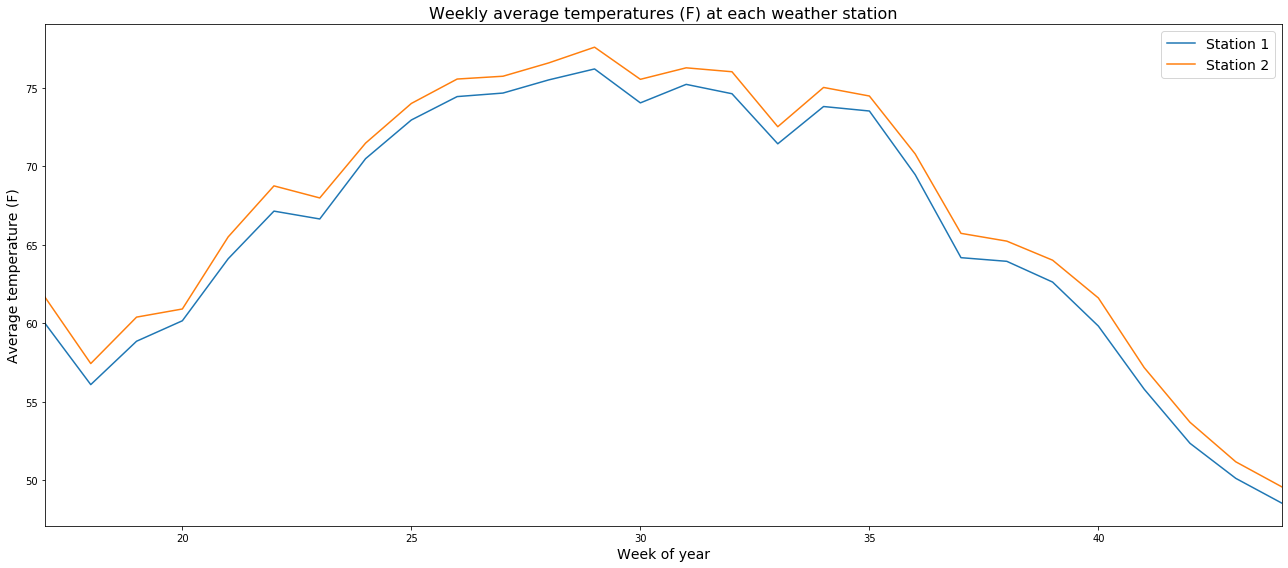

In [62]:
# plot weekly temperature by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'weekofyear',y = 'Tavg', data = weather[weather.Station==1], ci = None, label = "Station 1")
sns.lineplot(x = 'weekofyear',y = 'Tavg', data = weather[weather.Station==2], ci = None, label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly average temperatures (F) at each weather station', fontsize=16)
plt.xlabel('Week of year',fontsize=14)
plt.ylabel('Average temperature (F)',fontsize=14)
plt.xlim(weather.weekofyear.min(), weather.weekofyear.max())
plt.tight_layout()

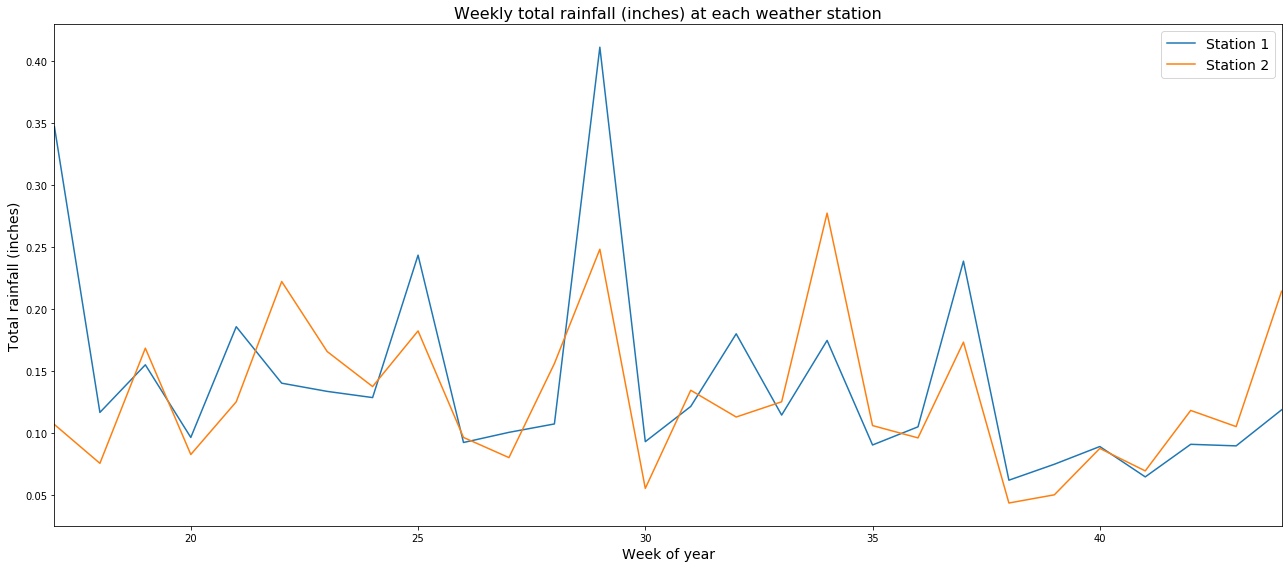

In [63]:
# plot weekly rainfall by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'weekofyear',y = 'PrecipTotal',data = weather[weather.Station==1],ci = None,label = "Station 1")
sns.lineplot(x = 'weekofyear',y = 'PrecipTotal',data = weather[weather.Station==2],ci = None,label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly total rainfall (inches) at each weather station', fontsize=16)
plt.xlabel('Week of year',fontsize=14)
plt.ylabel('Total rainfall (inches)',fontsize=14)
plt.xlim(weather.weekofyear.min(), weather.weekofyear.max())
plt.tight_layout()

From the graphs above, there are in fact discrepancies between the data captured which may likely be due to the difference in distance between the 2 stations. However, the discrepancies between the 2 weather stations seem to be insignificant visually especially from the graph showing the average temperature. As we do not require the same type of data for the same date, we will adopt a conservative approach and combine the data for each weather station by taking the average as the new value on the basis that:
- the discrepancies do not vary significantly (no presence of outliers)

### Combine data from both stations

In [64]:
# combine data from the 2 weather stations
weather_combined = weather.groupby('Date').mean()
weather_combined.drop(['Station', 'year','month','weekofyear'],axis=1,inplace=True)
weather_combined.reset_index(inplace=True)

In [65]:
# adding year/month/week columns back as they were previously affected by the groupby function and removed
weather_combined['year'] = weather_combined['Date'].apply(lambda x:x.year)
weather_combined['month'] = weather_combined['Date'].apply(lambda x:x.month)
weather_combined['weekofyear'] = weather_combined['Date'].apply(lambda x:x.weekofyear)

In [66]:
weather_combined.head()

Date  Tmax  Tmin  Tavg  DewPoint  PrecipTotal  StnPressure  \
0 2007-05-01  83.5  51.0  67.5      51.0          0.0       29.140   
1 2007-05-02  59.5  42.5  51.5      42.0          0.0       29.410   
2 2007-05-03  66.5  47.0  57.0      40.0          0.0       29.425   
3 2007-05-04  66.0  49.0  58.0      41.0          0.0       29.310   
4 2007-05-05  66.0  53.5  60.0      38.5          0.0       29.430   

   ResultSpeed  ResultDir  AvgSpeed  year  month  weekofyear  
0         2.20       26.0      9.40  2007      5          18  
1        13.15        3.0     13.40  2007      5          18  
2        12.30        6.5     12.55  2007      5          18  
3        10.40        8.0     10.80  2007      5          18  
4        11.45        7.0     11.75  2007      5          18

### Engineer some new features

**1. `Tavg` x (`PrecipTotal` + 1)**<br>
Temperature may have synergistic effects on the mosquito life cycle with precipitation. 1 is added to `PrecipTotal` to keep the `Tavg` value unchanged when `PrecipTotal` = 0 (i.e. no rain).

**2. Relative humidity**

**3. Temperature range**

**4. Delayed weather measurements**<br>
The average life cycle (eggs - adult) of a <i>Culex</i> mosquito is 14 days (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5654580/). Therefore, new columns will be created with the various weather columns being offset by 14 days.

In [67]:
weather_combined

Date  Tmax  Tmin  Tavg  DewPoint  PrecipTotal  StnPressure  \
0    2007-05-01  83.5  51.0  67.5      51.0        0.000       29.140   
1    2007-05-02  59.5  42.5  51.5      42.0        0.000       29.410   
2    2007-05-03  66.5  47.0  57.0      40.0        0.000       29.425   
3    2007-05-04  66.0  49.0  58.0      41.0        0.000       29.310   
4    2007-05-05  66.0  53.5  60.0      38.5        0.000       29.430   
...         ...   ...   ...   ...       ...          ...          ...   
1466 2014-10-27  78.0  52.5  65.5      51.5        0.010       28.960   
1467 2014-10-28  67.0  46.5  57.0      39.0        0.015       29.190   
1468 2014-10-29  49.0  38.0  44.0      33.0        0.000       29.390   
1469 2014-10-30  52.0  34.5  43.5      34.5        0.000       29.375   
1470 2014-10-31  48.0  33.5  41.0      27.0        0.035       29.515   

      ResultSpeed  ResultDir  AvgSpeed  year  month  weekofyear  
0            2.20       26.0      9.40  2007      5          18  
1           13.15        3.0     13.40  2007      5          18  
2           12.30        6.5     12.55  2007      5          18  
3           10.40        8.0     10.80  2007      5          18  
4           11.45        7.0     11.75  2007      5          18  
...           ...        ...       ...   ...    ...         ...  
1466        12.35       19.0     13.25  2014     10          44  
1467        14.40       26.0     15.10  2014     10          44  
1468         9.00       29.0      9.45  2014     10          44  
1469         5.50       23.5      6.00  2014     10          44  
1470        22.15       34.0     22.75  2014     10          44  

[1471 rows x 13 columns]

In [68]:
# temp x precip
weather_combined['temp_x_precip'] = weather_combined.Tavg * (weather_combined.PrecipTotal + 1)

# humidity
Tavg_C = ((weather_combined['Tavg'] - 32) * 5 / 9)
DewPoint_C = ((weather_combined['DewPoint'] - 32) * 5 / 9)
VapPress_Sat = np.exp((17.625 * Tavg_C) / (Tavg_C + 243.04))
VapPress_Act = np.exp((17.625 * DewPoint_C) / (DewPoint_C + 243.04))
R_Humidity = (VapPress_Act / VapPress_Sat) * 100

weather_combined['rh'] = R_Humidity

# temperature range
weather_combined['Trange'] = weather_combined['Tmax'] - weather_combined['Tmin']

In [69]:
# delayed columns
weather_combined['tavg_14d'] = weather_combined.Tavg.shift(periods=14)
weather_combined['dewpoint_14d'] = weather_combined.DewPoint.shift(periods=14)
weather_combined['precip_14d'] = weather_combined.PrecipTotal.shift(periods=14)
weather_combined['pressure_14d'] = weather_combined.StnPressure.shift(periods=14)
weather_combined['speed_14d'] = weather_combined.AvgSpeed.shift(periods=14)
weather_combined['temp_x_precip_14d'] = weather_combined.temp_x_precip.shift(periods=14)
weather_combined['rh_14d'] = weather_combined.rh.shift(periods=14)
weather_combined['trange_14d'] = weather_combined.Trange.shift(periods=14)

# drop first 14 rows since shifted rows won't have data
weather_combined.dropna(inplace=True)

In [70]:
weather_combined.head()

Date  Tmax  Tmin  Tavg  DewPoint  PrecipTotal  StnPressure  \
14 2007-05-15  81.0  56.5  69.0      56.0        0.490       29.160   
15 2007-05-16  65.0  44.5  55.0      42.5        0.105       29.360   
16 2007-05-17  61.5  43.5  53.0      32.0        0.000       29.585   
17 2007-05-18  70.5  42.5  57.0      30.5        0.000       29.565   
18 2007-05-19  80.0  56.0  68.0      38.0        0.000       29.375   

    ResultSpeed  ResultDir  AvgSpeed  ...         rh  Trange  tavg_14d  \
14          8.1       26.0     11.55  ...  63.268000    24.5      67.5   
15          7.9       36.0     12.00  ...  62.673283    20.5      51.5   
16         11.1        2.0     11.75  ...  44.606027    18.0      57.0   
17          4.4       23.5      6.50  ...  36.298247    28.0      58.0   
18         11.1       23.5     11.40  ...  33.232525    24.0      60.0   

    dewpoint_14d  precip_14d  pressure_14d  speed_14d  temp_x_precip_14d  \
14          51.0         0.0        29.140       9.40               67.5   
15          42.0         0.0        29.410      13.40               51.5   
16          40.0         0.0        29.425      12.55               57.0   
17          41.0         0.0        29.310      10.80               58.0   
18          38.5         0.0        29.430      11.75               60.0   

       rh_14d  trange_14d  
14  55.473252        32.5  
15  69.892062        17.0  
16  52.927763        19.5  
17  53.075889        17.0  
18  44.835308        12.5  

[5 rows x 24 columns]

### Drop extra columns

In [71]:
# drop codesum as most of it is rain, which is captured in precip
weather.CodeSum.value_counts()

                    1599
RA                   295
RA BR                237
BR                   110
TSRA RA BR            92
                    ... 
TSRA FG+ BR            1
RA FG BR               1
FG+                    1
TS TSRA GR RA BR       1
BR HZ VCFG             1
Name: CodeSum, Length: 98, dtype: int64

In [72]:
# drop unnecesary columns (including those that station 2 doesn't record)
col_to_drop = ['Tmax','Tmin','ResultSpeed','ResultDir']
weather_combined.drop(col_to_drop, axis = 1,inplace=True)

### Univariate EDA

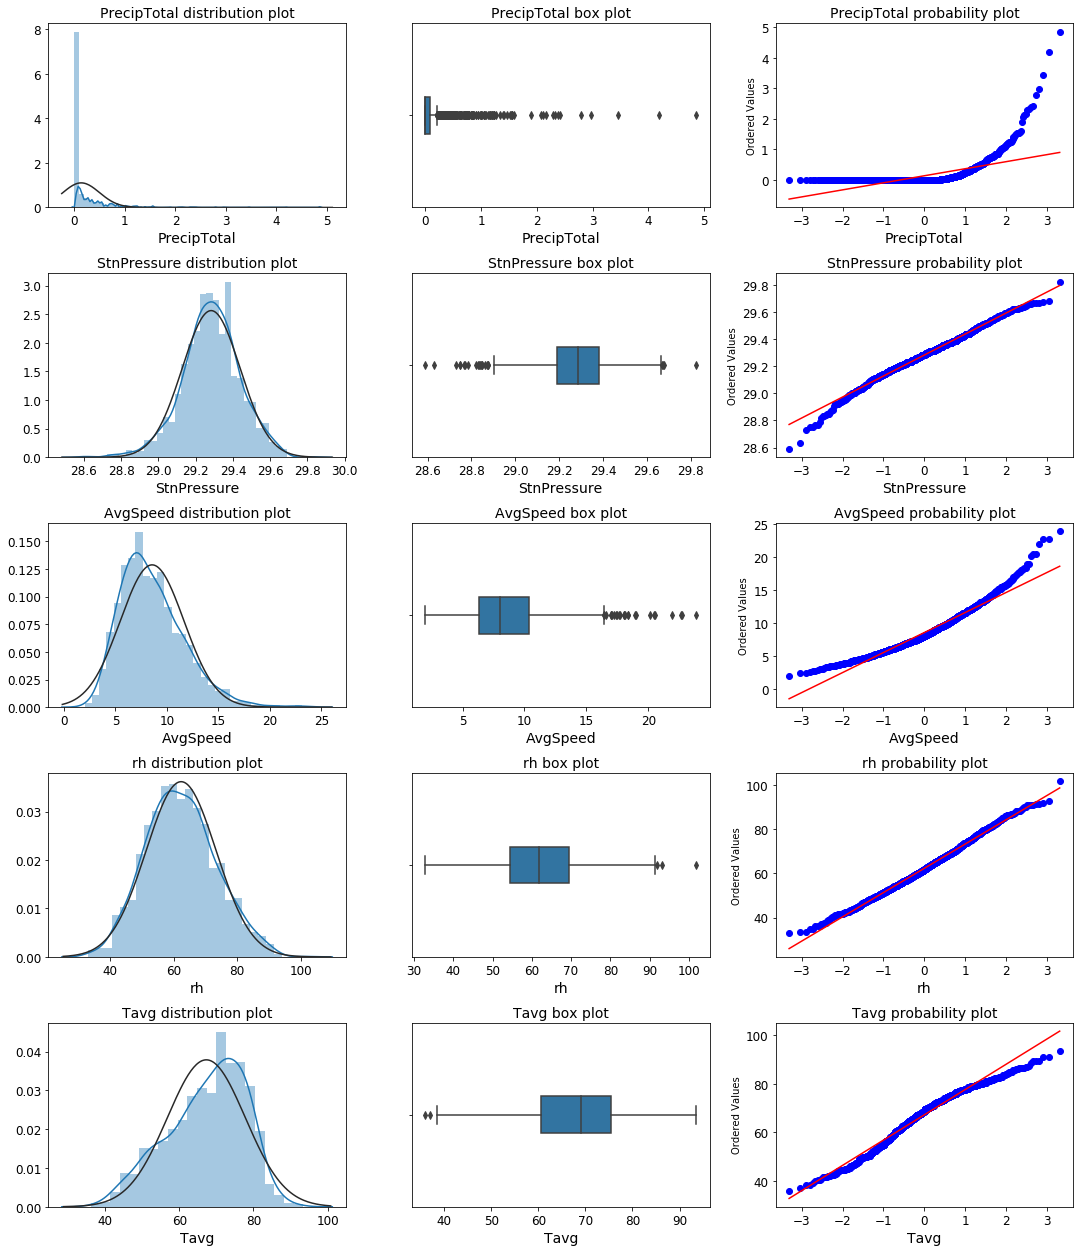

In [73]:
dist_plots(weather_combined,['Tavg', 'PrecipTotal', 'StnPressure', 'AvgSpeed', 'rh',])

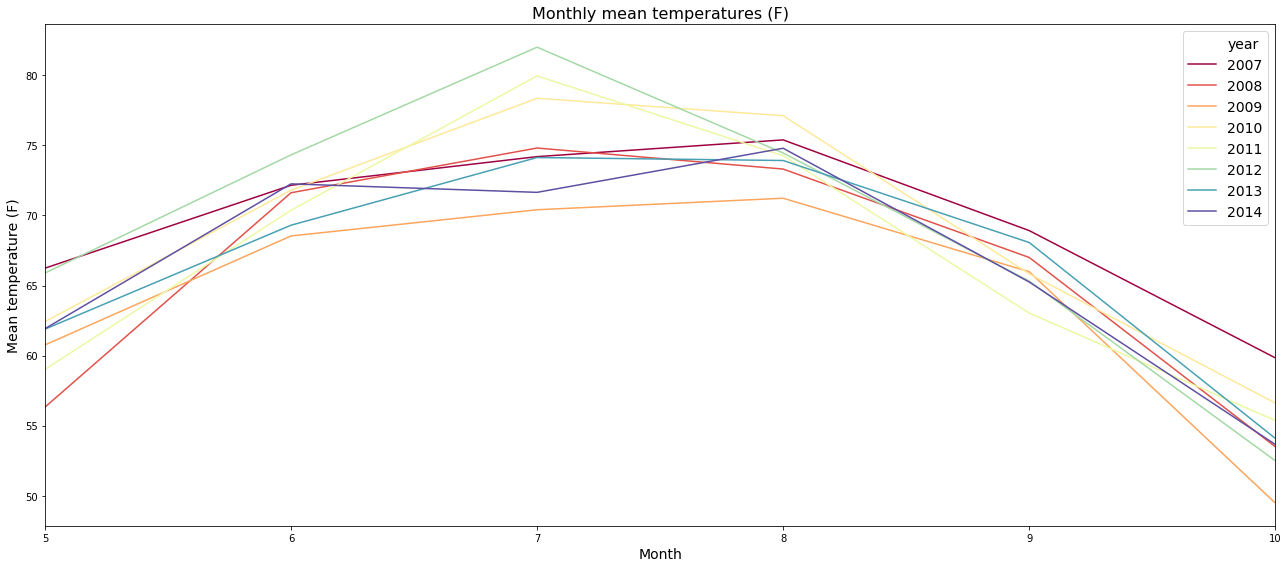

In [74]:
# plot temperature by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'Tavg', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean temperatures (F)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean temperature (F)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

Generally, the temperature cycle climbs from May to August and peak in July (with the exception of 2007 and 2014 where the peak is in August) before starting to decrease from August.

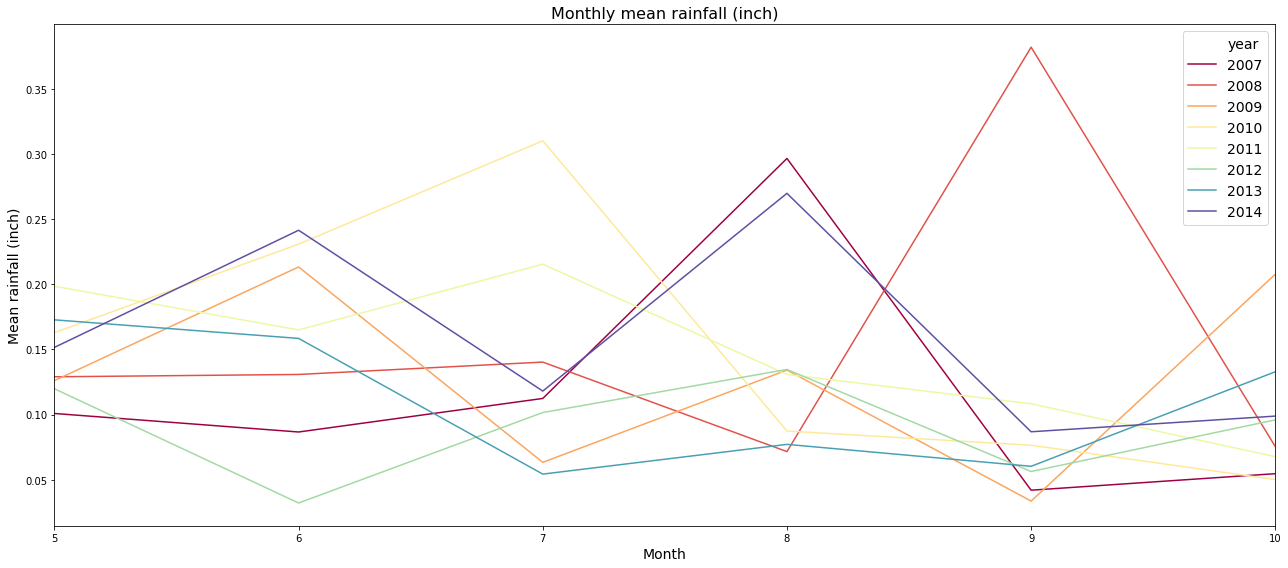

In [75]:
# plot rainfall by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'PrecipTotal', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean rainfall (inch)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean rainfall (inch)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

There is no distinct pattern in the average amount of rainfall as it varies from year to year. However, it does look have an exceptionally high amount of average rainfall in September 2008.

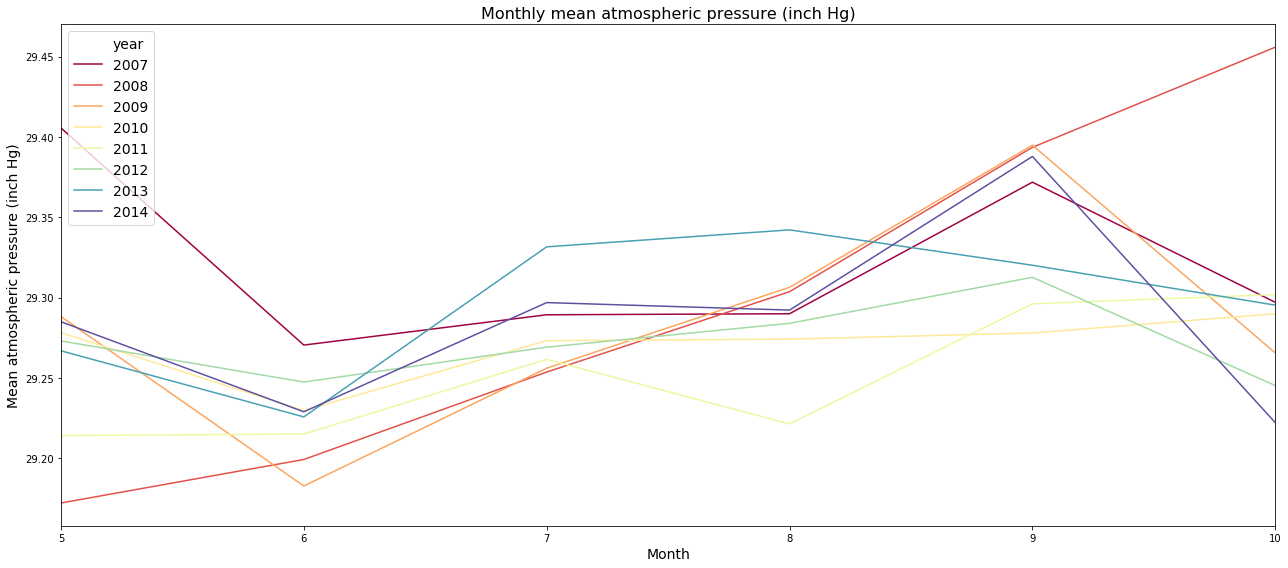

In [76]:
# plot atmospheric pressure by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'StnPressure', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(loc = 'upper left', fontsize = 14)
plt.title('Monthly mean atmospheric pressure (inch Hg)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean atmospheric pressure (inch Hg)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

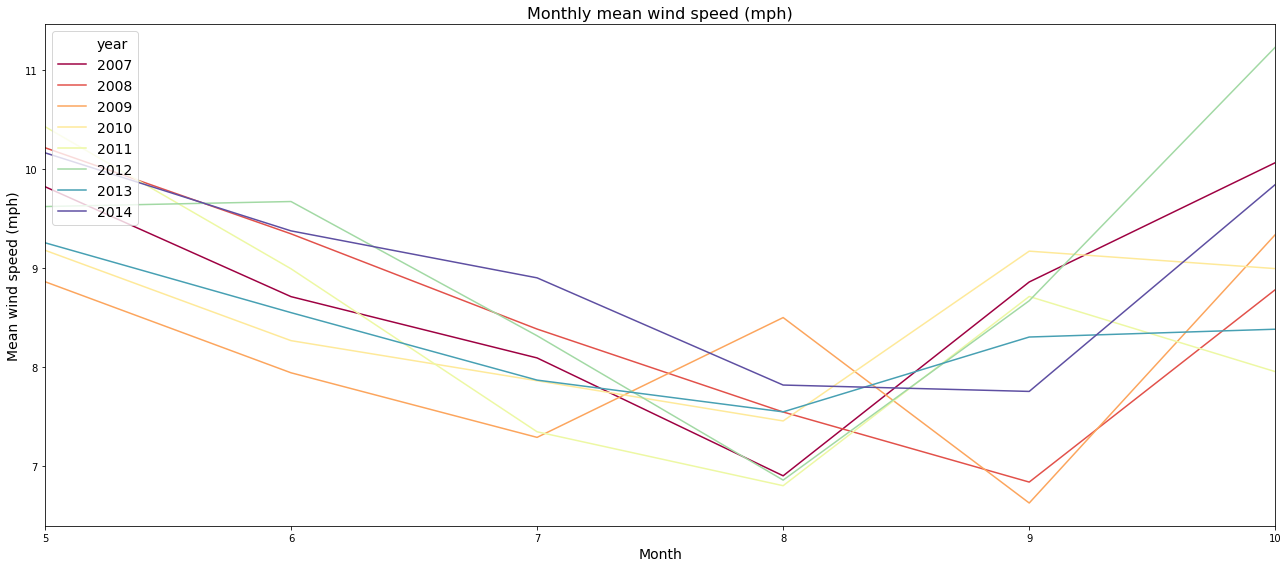

In [77]:
# plot wind speed by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'AvgSpeed', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(loc = 'upper left', fontsize = 14)
plt.title('Monthly mean wind speed (mph)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean wind speed (mph)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

### Bivariate EDA

#### Combine weather + traps

In [78]:
trap.head()

Date                                           Address  \
0  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2  2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3  2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4  2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  ...  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8  ...   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8  ...   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8  ...   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8  ...   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8  ...   

   Year  Month  Day  Week n3_intersect_dates  n3_spray_sets n3_spray_geom  \
0  2007      5   29    22               None           None          None   
1  2007      5   29    22               None           None          None   
2  2007      5   29    22               None           None          None   
3  2007      5   29    22               None           None          None   
4  2007      5   29    22               None           None          None   

  n3_spray_coord n3_spray_dist_deg  n3_spray_dist_m  
0           None              None             None  
1           None              None             None  
2           None              None             None  
3           None              None             None  
4           None              None             None  

[5 rows x 29 columns]

In [79]:
weather_combined

Date  Tavg  DewPoint  PrecipTotal  StnPressure  AvgSpeed  year  \
14   2007-05-15  69.0      56.0        0.490       29.160     11.55  2007   
15   2007-05-16  55.0      42.5        0.105       29.360     12.00  2007   
16   2007-05-17  53.0      32.0        0.000       29.585     11.75  2007   
17   2007-05-18  57.0      30.5        0.000       29.565      6.50  2007   
18   2007-05-19  68.0      38.0        0.000       29.375     11.40  2007   
...         ...   ...       ...          ...          ...       ...   ...   
1466 2014-10-27  65.5      51.5        0.010       28.960     13.25  2014   
1467 2014-10-28  57.0      39.0        0.015       29.190     15.10  2014   
1468 2014-10-29  44.0      33.0        0.000       29.390      9.45  2014   
1469 2014-10-30  43.5      34.5        0.000       29.375      6.00  2014   
1470 2014-10-31  41.0      27.0        0.035       29.515     22.75  2014   

      month  weekofyear  temp_x_precip         rh  Trange  tavg_14d  \
14        5          20        102.810  63.268000    24.5      67.5   
15        5          20         60.775  62.673283    20.5      51.5   
16        5          20         53.000  44.606027    18.0      57.0   
17        5          20         57.000  36.298247    28.0      58.0   
18        5          20         68.000  33.232525    24.0      60.0   
...     ...         ...            ...        ...     ...       ...   
1466     10          44         66.155  60.558531    25.5      63.5   
1467     10          44         57.855  50.906282    20.5      60.0   
1468     10          44         44.000  65.027775    11.0      54.5   
1469     10          44         43.500  70.377290    17.5      54.5   
1470     10          44         42.435  57.174862    14.5      55.5   

      dewpoint_14d  precip_14d  pressure_14d  speed_14d  temp_x_precip_14d  \
14            51.0       0.000        29.140       9.40            67.5000   
15            42.0       0.000        29.410      13.40            51.5000   
16            40.0       0.000        29.425      12.55            57.0000   
17            41.0       0.000        29.310      10.80            58.0000   
18            38.5       0.000        29.430      11.75            60.0000   
...            ...         ...           ...        ...                ...   
1466          59.5       0.540        29.000       9.00            97.7900   
1467          58.0       0.915        28.860       9.40           114.9000   
1468          52.0       0.060        29.075       9.80            57.7700   
1469          50.5       0.000        29.055       7.90            54.5000   
1470          47.0       0.005        29.020      12.95            55.7775   

         rh_14d  trange_14d  
14    55.473252        32.5  
15    69.892062        17.0  
16    52.927763        19.5  
17    53.075889        17.0  
18    44.835308        12.5  
...         ...         ...  
1466  86.810912        11.5  
1467  93.101371        13.0  
1468  91.246467         5.0  
1469  86.324942         5.5  
1470  73.035927        14.0  

[1457 rows x 20 columns]

In [80]:
weather_combined.drop(['year','month','weekofyear'], axis=1, inplace=True)
combined = pd.merge(trap, weather_combined, how = 'left', left_on = 'Date', right_on = 'Date')
combined.head()

Date                                           Address  \
0  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2  2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3  2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4  2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  ...  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8  ...   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8  ...   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8  ...   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8  ...   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8  ...   

          rh  Trange  tavg_14d  dewpoint_14d precip_14d  pressure_14d  \
0  55.578334    25.5      69.0          56.0       0.49         29.16   
1  55.578334    25.5      69.0          56.0       0.49         29.16   
2  55.578334    25.5      69.0          56.0       0.49         29.16   
3  55.578334    25.5      69.0          56.0       0.49         29.16   
4  55.578334    25.5      69.0          56.0       0.49         29.16   

  speed_14d temp_x_precip_14d  rh_14d  trange_14d  
0     11.55            102.81  63.268        24.5  
1     11.55            102.81  63.268        24.5  
2     11.55            102.81  63.268        24.5  
3     11.55            102.81  63.268        24.5  
4     11.55            102.81  63.268        24.5  

[5 rows x 45 columns]

#### Pairplot

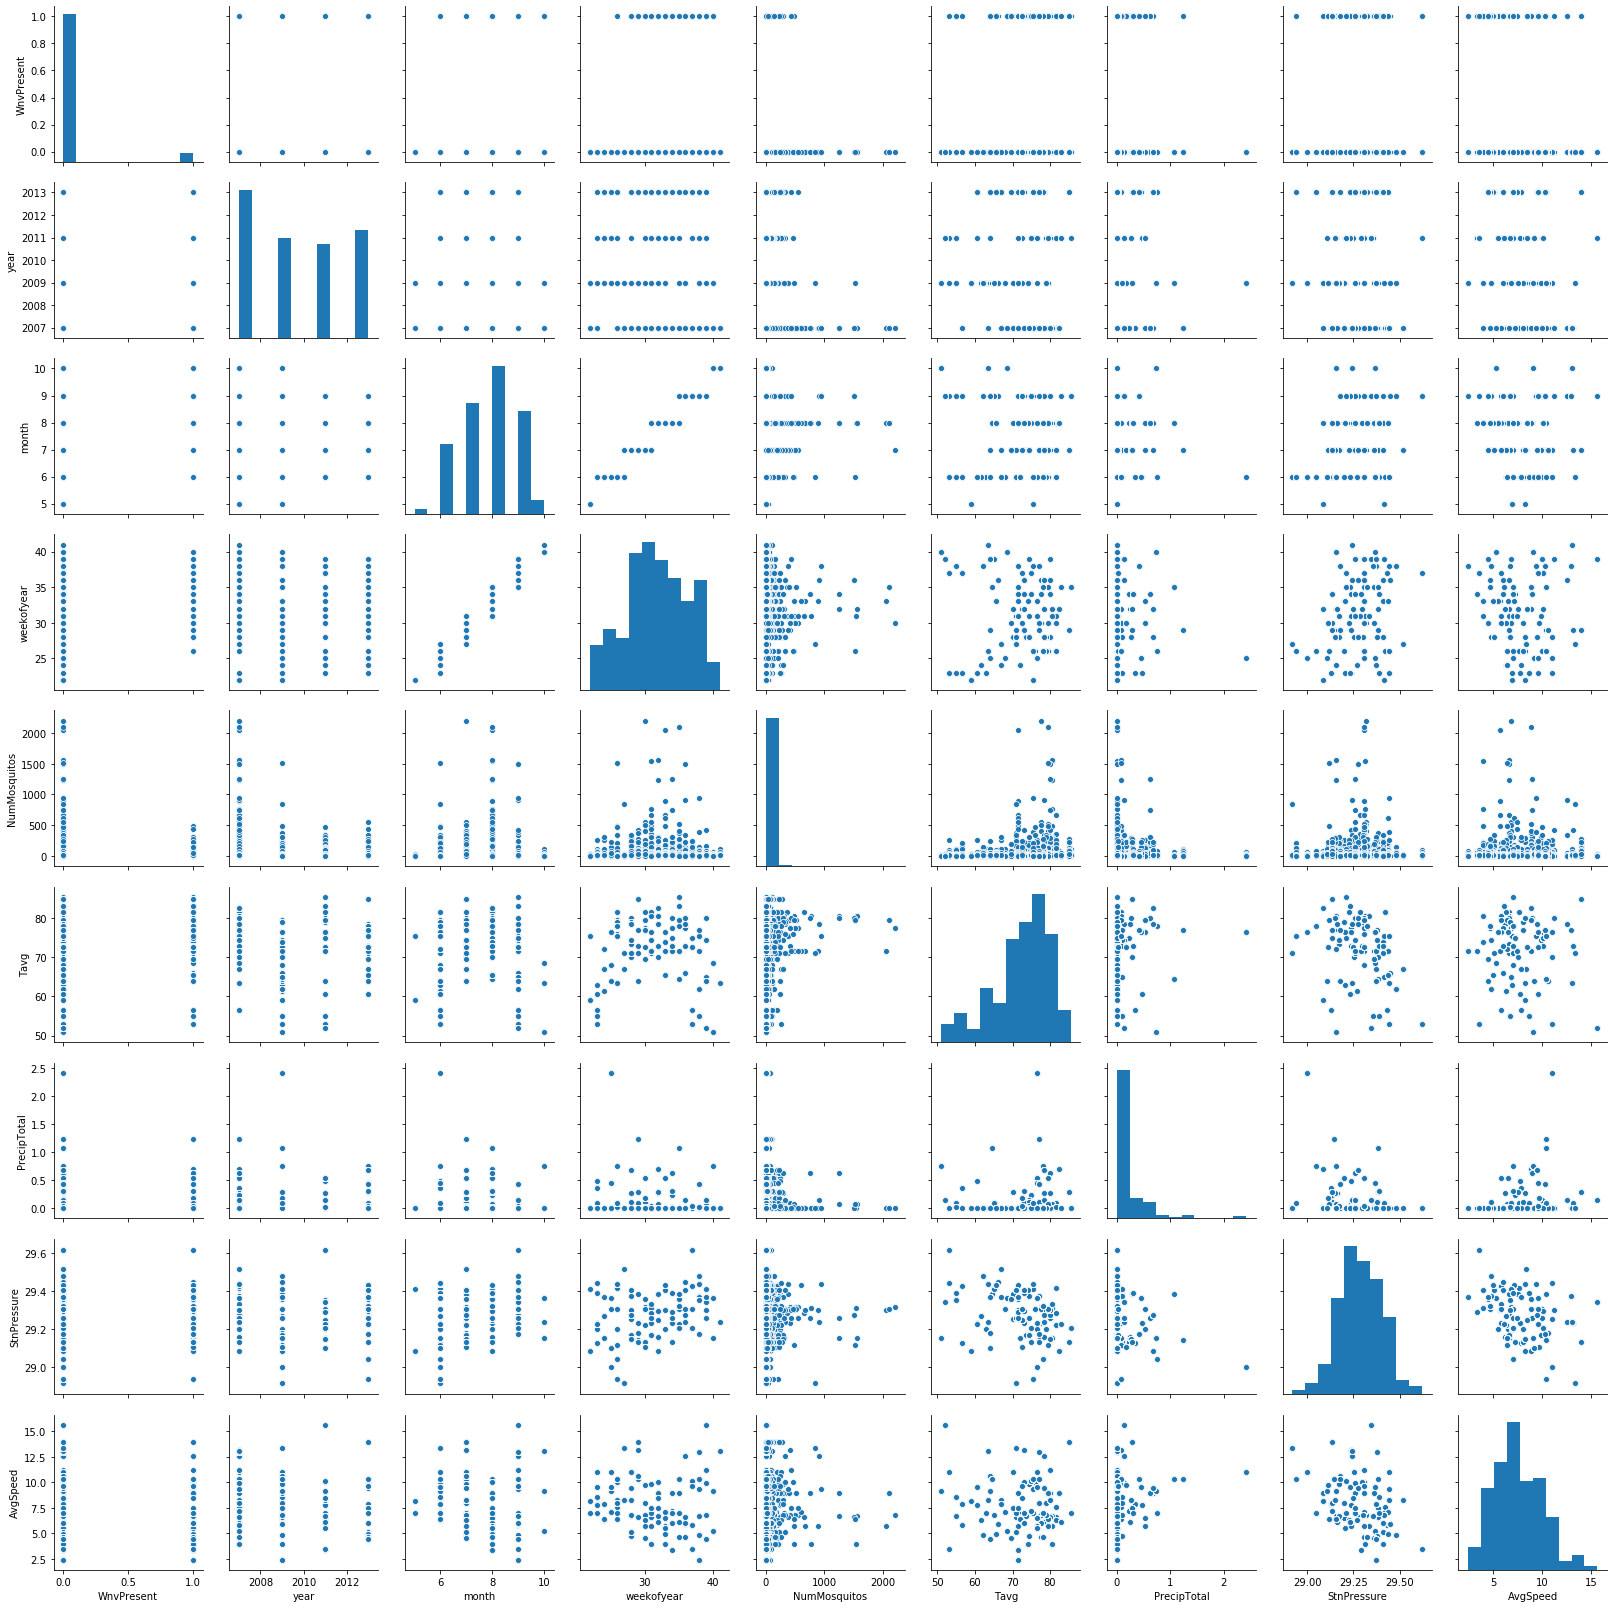

In [81]:
sns.pairplot(combined[['WnvPresent','year','month','weekofyear','NumMosquitos','Tavg',\
                       'PrecipTotal','StnPressure','AvgSpeed']])

#### Correlation heatmap

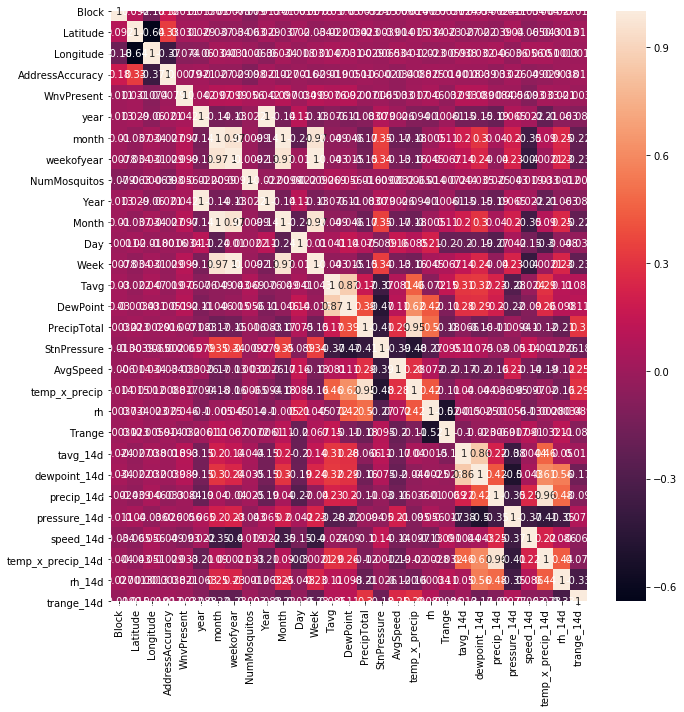

In [82]:
plt.figure(figsize=(10,10))
sns.heatmap(combined.corr(), annot = True)
plt.tight_layout()

no obvious correlation here

#### Map

WNV is most prevalent in August and September. Some years are worse than others. This may be due to factors such as temp and precip.

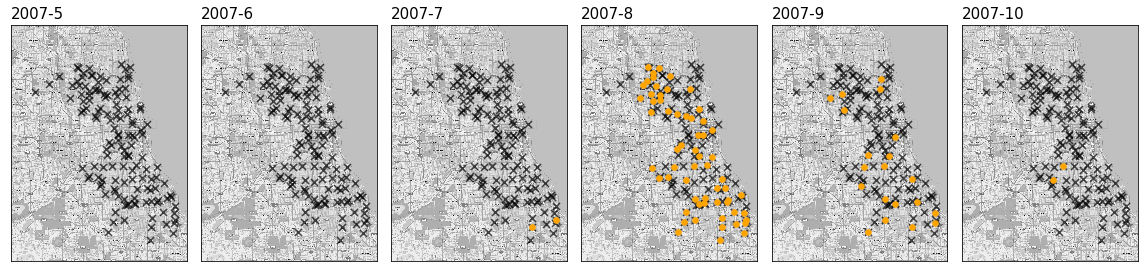

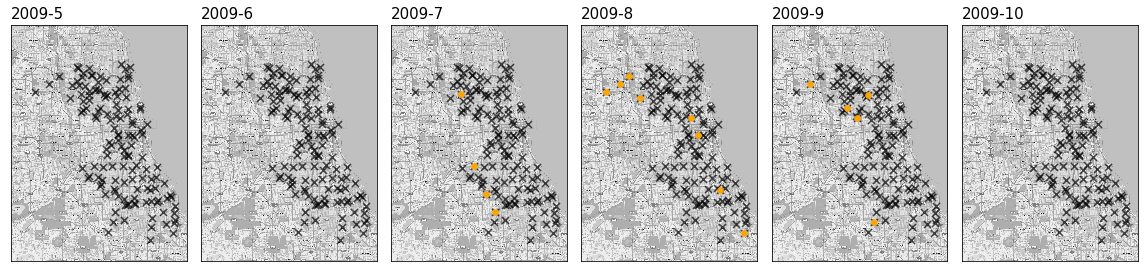

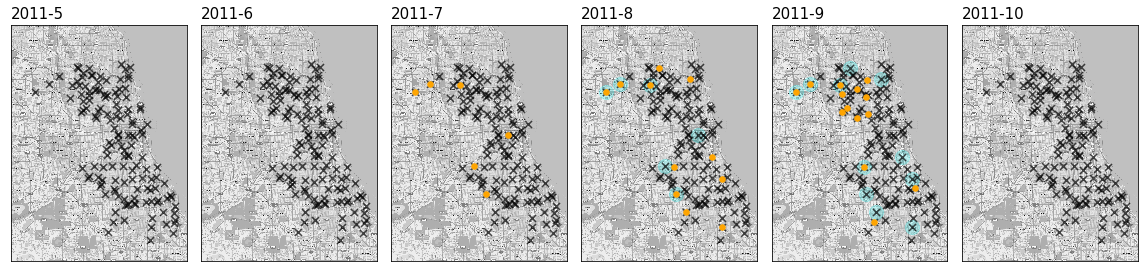

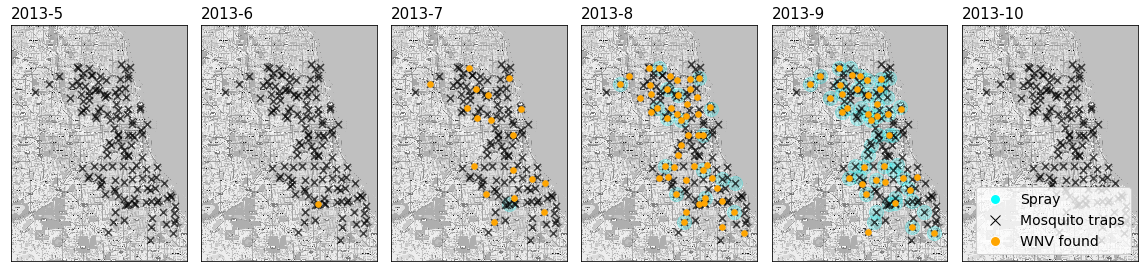

In [83]:
# plot spray data
spray1['year'] = spray1.Date.apply(lambda x:x.year)
spray1['month'] = spray1.Date.apply(lambda x:x.month)

# set up basemap
mapdata = np.loadtxt("./assets/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# create plot for each month and year 
for year in combined.year.unique():
    fig, ax = plt.subplots(ncols = 6, figsize = (16,5))
    
    for i, month in enumerate([5,6,7,8,9,10]):
        # plot basemap
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
        
        # plot spray locations for year and month
        if year in spray1.year.unique() and month in spray1.month.unique():
            sprayed = spray1[(spray1.year == year) & (spray1.month == month)][['Longitude', 'Latitude']].drop_duplicates().values
            ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'cyan', s = 200, alpha = 0.2)
        
        # plot trap locations
        locations = combined[['Longitude', 'Latitude']].drop_duplicates().values
        ax[i].scatter(locations[:,0], locations[:,1], marker='x', c = 'black', s=50, alpha = 0.7)
        
        # plot wnv locations for year and month
        wnv = combined[(combined.year == year) & (combined.month == month) & (combined.WnvPresent == 1)]\
                [['Longitude', 'Latitude']].drop_duplicates().values
        ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'orange', s = 30)
        
        # title and axes
        ax[i].set_title(f"{year}-{month}", fontsize = 15, ha = 'left', position = (0,1))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        plt.tight_layout()
#         plt.savefig(f'heatmap_{year}_{month}')

# custom legend
legend_elements=[Line2D([0],[0],marker='o', color='w',label='Spray', markerfacecolor='cyan', markersize=10),
                 Line2D([0],[0],marker='x', color='black', label='Mosquito traps',linestyle='', markersize=10),
                 Line2D([0],[0],marker='o', color='w',label='WNV found',markerfacecolor='orange', markersize=10)]

plt.legend(handles=legend_elements, loc='lower right', fontsize=14)
plt.tight_layout()

# Preprocessing

In [84]:
# define preprocessing function

def preprocess_train(trap_df, weather_df):
    
    # ---------------------------------- MAKE NEW COLUMNS -------------------------------------
    # datetime
    trap_df['month'] = trap_df['Date'].apply(lambda x:x.month)
    trap_df['weekofyear'] = trap_df['Date'].apply(lambda x:x.weekofyear)
    trap_df['dayofyear'] = trap_df['Date'].apply(lambda x:x.dayofyear)

    # locations
    trap_df['LatLong'] = [(x, y) for x, y in zip(trap_df['Latitude'], trap_df['Longitude'])]
#     trap_df['Coord'] = [Point(x, y) for x, y in zip(trap_df['Latitude'], trap_df['Longitude'])]
    
    # ---------------------------------- JOIN WITH WEATHER -------------------------------------
    # combine with weather
    df = pd.merge(trap_df, weather_df, how = 'left', left_on = 'Date', right_on = 'Date')
   
    # ------------------------------- DROP UNNECESSARY COLUMNS -------------------------------
    cols_to_drop = ['Date','NumMosquitos','Trap','Address','Block','Street','AddressNumberAndStreet',\
                    'AddressAccuracy','year','yearmonth']
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    return df

# this is same as the function for train except without 'NumMosquitos','year', and 'yearmonth'
def preprocess_test(trap_df, weather_df):
    
    # ---------------------------------- MAKE NEW COLUMNS -------------------------------------
    # datetime
    trap_df['month'] = trap_df['Date'].apply(lambda x:x.month)
    trap_df['weekofyear'] = trap_df['Date'].apply(lambda x:x.weekofyear)
    trap_df['dayofyear'] = trap_df['Date'].apply(lambda x:x.dayofyear)

    # locations
    trap_df['LatLong'] = [(x, y) for x, y in zip(trap_df['Latitude'], trap_df['Longitude'])]
#     trap_df['Coord'] = [Point(x, y) for x, y in zip(trap_df['Latitude'], trap_df['Longitude'])]
    
    # ---------------------------------- JOIN WITH WEATHER -------------------------------------
    # combine with weather
    df = pd.merge(trap_df, weather_df, how = 'left', left_on = 'Date', right_on = 'Date')
    
    # ------------------------------- DROP UNNECESSARY COLUMNS -------------------------------
    cols_to_drop = ['Date','Trap','Address','Block','Street','AddressNumberAndStreet',\
                    'AddressAccuracy']
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    return df

In [92]:
trap1.head()

Date                                           Address  \
0  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2  2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3  2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4  2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  ...  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8  ...   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8  ...   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8  ...   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8  ...   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8  ...   

   Year  Month  Day  Week n3_intersect_dates  n3_spray_sets n3_spray_geom  \
0  2007      5   29    22               None           None          None   
1  2007      5   29    22               None           None          None   
2  2007      5   29    22               None           None          None   
3  2007      5   29    22               None           None          None   
4  2007      5   29    22               None           None          None   

  n3_spray_coord n3_spray_dist_deg  n3_spray_dist_m  
0           None              None             None  
1           None              None             None  
2           None              None             None  
3           None              None             None  
4           None              None             None  

[5 rows x 29 columns]

In [90]:
# process train data
trap1 = trap.copy()
trap_processed = preprocess_train(trap1, weather_combined)

# process test data
test = pd.read_csv('./assets/test.csv', index_col=0, parse_dates =['Date'])
test_processed = preprocess_test(test, weather_combined)

AttributeError: 'datetime.date' object has no attribute 'weekofyear'

## Automated feature engineering

### Convert data to int/float32

In [ ]:
def convert_columns(df):  
    for col in df.columns:    
        col_type = df[col].dtype
        if (col_type == 'object'):
                df[col] = df[col].astype('category')    
        if (col_type == 'int64'):
                df[col] = df[col].astype('int32')   
        if (col_type == 'float64'):
                df[col] = df[col].astype('float32')  
    return df

trap_processed = convert_columns(trap_processed)
test_processed = convert_columns(test_processed)

### Separate x and y columns in training set

In [ ]:
x = trap_processed.loc[:, trap_processed.columns != 'WnvPresent']
y = trap_processed[['WnvPresent']]

print(x.shape)
print(y.shape)

### Create entities

In [ ]:
entity_set_train = ft.EntitySet(id = 'train')
entity_set_train = entity_set_train.entity_from_dataframe(entity_id = 'train',
                                                          dataframe = x,
                                                          index ='...', )
#                                                           make_index=True)

entity_set_test = ft.EntitySet(id = 'test')
entity_set_test = entity_set_test.entity_from_dataframe(entity_id = 'test',
                                                        dataframe = test_processed,
                                                        index ='...', 
                                                        make_index=True)

In [ ]:
# check that it has read all the data in
print(entity_set_train)
print(entity_set_test)

### Create primitives

In [ ]:
list_of_primitives = ft.primitives.list_primitives()
agg = list_of_primitives[list_of_primitives.type == 'aggregation']
trans = list_of_primitives[list_of_primitives.type == 'transform']

In [ ]:
trans

In [ ]:
# the agg primitives aren't really relevant
# select list of transform primitives to use on data
trans_primitives = ['multiply_numeric','percentile', 'cum_mean','cum_sum','haversine','and',
                   'divide_by_feature','subtract_numeric','diff','add_numeric']

### Create features using the deep feature synthesis (dfs) object
Using the above primitives, `featuretools` produced 406 features, which is still acceptable given that our training data has 8610 rows.

In [ ]:
features_train, feature_names_train = ft.dfs(entityset = entity_set_train,
                                target_entity = 'train',
                                trans_primitives=trans_primitives,
                                max_depth =1,
                                verbose=True)

features_test, feature_names_test = ft.dfs(entityset = entity_set_test,
                                target_entity = 'test',
                                trans_primitives=trans_primitives,
                                max_depth =1,
                                verbose=True)

In [ ]:
# check columns for train (x only) and test sets
print(features_train.shape)
print(features_test.shape)

### Feature cleaning

In [ ]:
train_ft = features_train.copy().reset_index(drop=True)
test_ft = features_test.copy().reset_index(drop=True)

# drop columns with inf and nan
train_ft = train_ft.replace([np.inf, -np.inf], np.nan)
train_ft.dropna(axis=1, how='any', inplace=True)

test_ft = test_ft.replace([np.inf, -np.inf], np.nan)
test_ft.dropna(axis=1, how='any', inplace=True)

In [ ]:
train_ft.head()

In [ ]:
test_ft.head()

# Export processed CSVs

In [ ]:
# export training data
# join train x and train y again
train_ft2 = pd.merge(train_ft, y, left_on=train_ft.index, right_on=y.index)
train_ft2.drop('key_0', axis=1, inplace=True)
train_ft2.to_csv('./assets/train_processed.csv',index=False)

# export test data
test_ft.to_csv('./assets/test_processed.csv',index=False)